In [1]:
# === 0) SETUP ===
import os, time, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams["figure.figsize"] = (12,4)

TS = time.strftime("%Y%m%d-%H%M%S")
OUT_DIR = f"outputs_QA_EDA/{TS}"
os.makedirs(OUT_DIR, exist_ok=True)

def savefig_and_download(fig, name, dpi=160):
    """Save fig -> PNG, show in notebook, auto-download."""
    path = os.path.join(OUT_DIR, f"{name}.png")
    fig.tight_layout()
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"[saved] {path}")
    plt.show()
    try:
        files.download(path)
    except Exception as e:
        print("download skipped:", e)

def savecsv_and_download(df, name):
    """Save df -> CSV, auto-download."""
    path = os.path.join(OUT_DIR, f"{name}.csv")
    df.to_csv(path, index=False)
    print(f"[saved] {path}")
    try:
        files.download(path)
    except Exception as e:
        print("download skipped:", e)


In [2]:
# === 1) LOAD ===
orders = pd.read_excel("Sample_Customore_Order raw2.xlsx", sheet_name="raw")
traffic = pd.read_excel("Sample_Customore_Traffic raw.xlsx")

# Clean GRAND TOTAL row (nằm cuối GA export)
traffic_clean = traffic.copy()
if len(traffic_clean) >= 1:
    last = traffic_clean.tail(1).iloc[0]
    # Heuristic: nếu 'Source / Medium' bị NaN hoặc có từ 'total' thì coi là tổng
    sm = str(last.get("Source / Medium", "")).strip().lower()
    if (pd.isna(last.get("Source / Medium"))
        or "total" in sm
        or "grand" in sm):
        traffic_clean = traffic_clean.iloc[:-1].copy()

print("Traffic rows (raw → clean):", len(traffic), "→", len(traffic_clean))


# Excel serial date -> datetime
orders['created_day'] = pd.to_datetime(
    orders['created_day'], origin='1899-12-30', unit='D'
)


print("Orders shape:", orders.shape, "| Traffic shape:", traffic_clean.shape)
print("Orders date range:", orders["created_day"].min(), "→", orders["created_day"].max())


Traffic rows (raw → clean): 198 → 197
Orders shape: (61728, 11) | Traffic shape: (197, 10)
Orders date range: 2019-07-01 00:00:00 → 2019-07-30 00:00:00


In [3]:
# === 2) QA — EXPECTATIONS ===
issues = []

# 2.1 Schema expectation (tên cột & dtype kỳ vọng)
expected_cols = {
    "customer_unique_id":"int64",
    "order_id":"object",
    "item_quantity":"int64",
    "created_day":"datetime64[ns]",
    "onsite_original_price":"int64",
    "selling_price":"int64",
    "shipping_fee":"int64",
    "voucher_platform":"int64",
    "voucher_seller":"int64",
    "payment_method":"object",
    "order_status":"object",
}
missing = [c for c in expected_cols if c not in orders.columns]
if missing:
    issues.append(("missing_columns", ", ".join(missing)))

# 2.2 Nulls
nulls = orders.isna().sum()
null_critical = nulls[nulls > 0]
if not null_critical.empty:
    issues.append(("nulls_present", null_critical.to_dict()))

# 2.3 Business rules
bad_qty = orders.query("item_quantity <= 0")
if len(bad_qty): issues.append(("non_positive_quantity", int(len(bad_qty))))

neg_price = orders[(orders["selling_price"] < 0) | (orders["onsite_original_price"] < 0)]
if len(neg_price): issues.append(("negative_price_rows", int(len(neg_price))))

neg_ship = orders[orders["shipping_fee"] < 0]
if len(neg_ship): issues.append(("negative_shipping_fee", int(len(neg_ship))))

neg_voucher = orders[(orders["voucher_platform"] < 0) | (orders["voucher_seller"] < 0)]
if len(neg_voucher): issues.append(("negative_voucher", int(len(neg_voucher))))

viol_price_ceiling = orders[orders["selling_price"] > orders["onsite_original_price"]]
if len(viol_price_ceiling): issues.append(("selling_gt_original", int(len(viol_price_ceiling))))

# 2.4 Duplicates
row_dups = orders.duplicated().sum()
if row_dups: issues.append(("exact_row_duplicates", int(row_dups)))

# 2.5 Status & Payment distributions
status_counts = orders["order_status"].value_counts(dropna=False)
pay_counts = orders["payment_method"].value_counts(dropna=False)

# 2.6 Quick totals & completed subset
orders["line_revenue"] = orders["item_quantity"] * orders["selling_price"]
completed = orders[orders["order_status"] == "COMPLETED"].copy()
completed["line_revenue"] = completed["item_quantity"] * completed["selling_price"]

# 2.7 Lines per order_id
order_line_counts = orders.groupby("order_id").size().describe()

# Build QA summary (FIX: chiều dài cột khớp nhau)
if issues:
    qa_summary = pd.DataFrame(issues, columns=["check","result"])
else:
    qa_summary = pd.DataFrame([["no_issues","ok"]], columns=["check","result"])

print("=== QA SUMMARY ===")
display(qa_summary)

print("\n=== STATUS COUNTS ===")
display(status_counts.to_frame("count"))

print("\n=== PAYMENT METHODS ===")
display(pay_counts.to_frame("count"))

print("\n=== ORDER LINES PER ORDER_ID (describe) ===")
display(order_line_counts.to_frame().T)

# Save & download artifacts
savecsv_and_download(status_counts.reset_index().rename(columns={"index":"order_status"}), "qa_status_counts")
savecsv_and_download(pay_counts.reset_index().rename(columns={"index":"payment_method"}), "qa_payment_method_counts")
savecsv_and_download(qa_summary, "qa_summary_findings")


=== QA SUMMARY ===


,check,result
0,exact_row_duplicates,1897



=== STATUS COUNTS ===


,count
order_status,
COMPLETED,49717
CANCELLED,12011



=== PAYMENT METHODS ===


,count
payment_method,
Cash on Delivery,53988
Airpay GIRO,2804
Cybersource,1783
Airpay Wallet V2,1367
Shopee Wallet,366
VN Airpay Ibanking (Vietcombank),308
Cybersource (new),246
VN Airpay Ibanking (Techcombank),168
VN Airpay Ibanking (BIDV),124



=== ORDER LINES PER ORDER_ID (describe) ===


,count,mean,std,min,25%,50%,75%,max
0,37835.0,1.631505,0.97628,1.0,1.0,1.0,2.0,17.0


[saved] outputs_QA_EDA/20250920-155719/qa_status_counts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/qa_payment_method_counts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/qa_summary_findings.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_daily_revenue.png


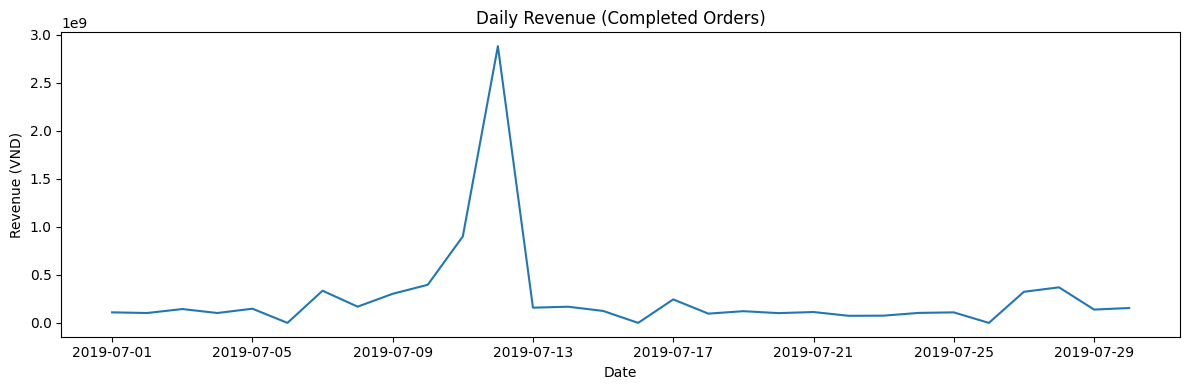

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_daily_orders_units.png


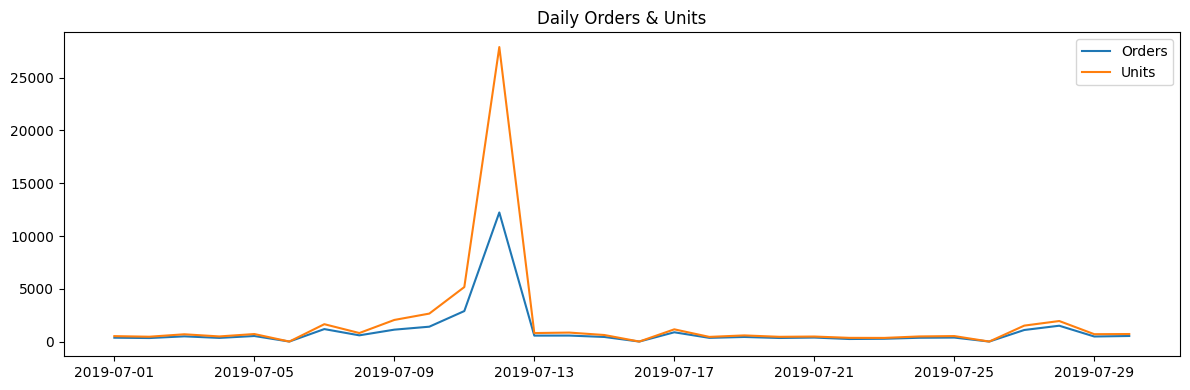

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_daily_aov.png


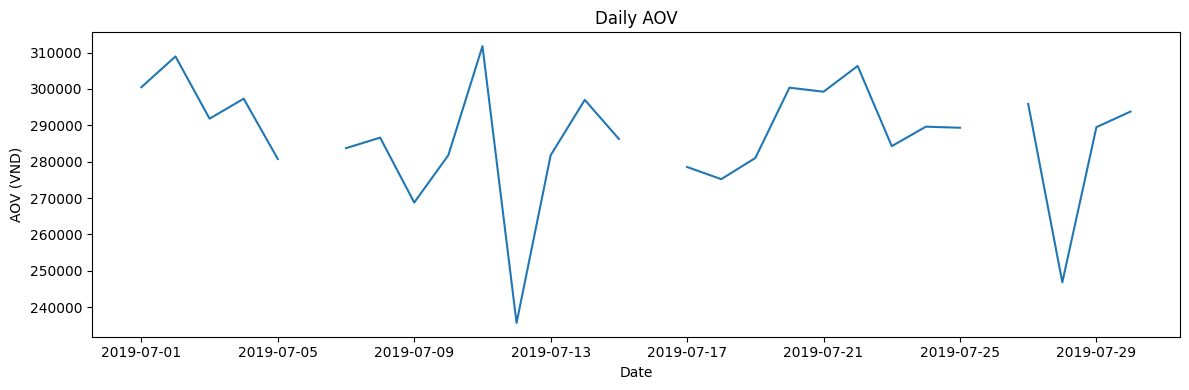

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_dow_revenue.png


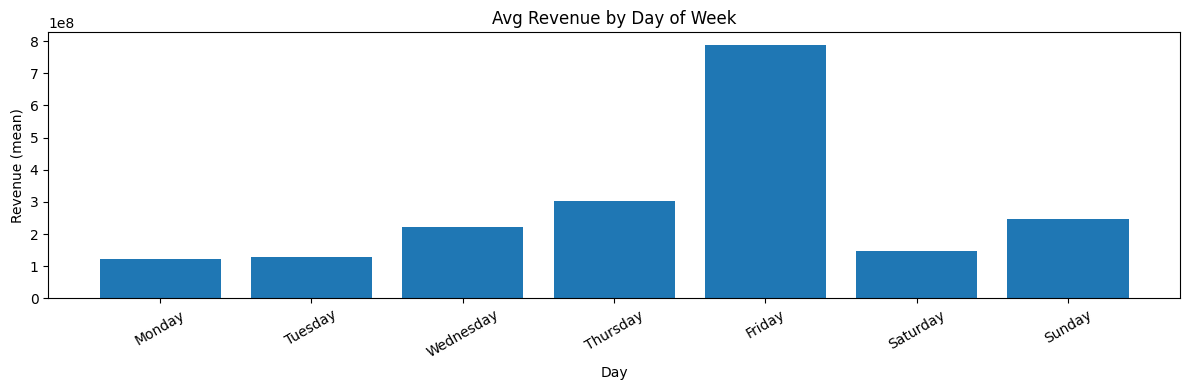

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_dow_aov.png


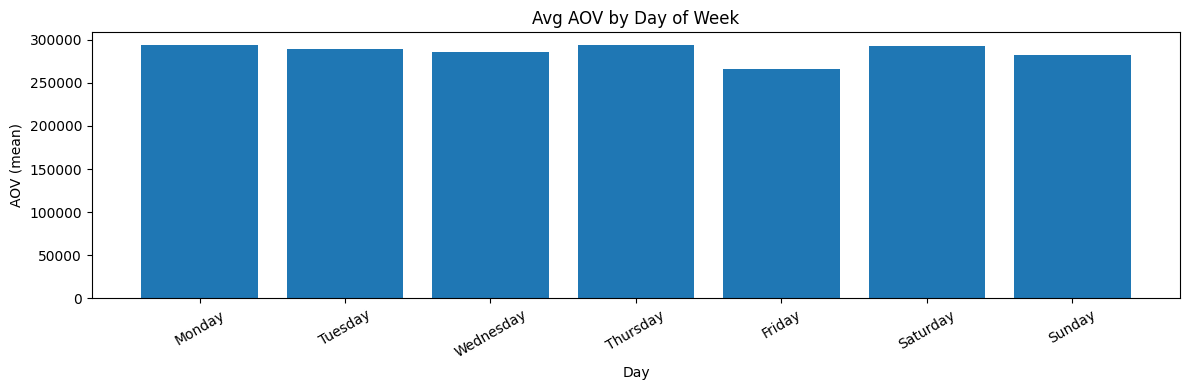

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_daily_timeseries.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_QA_EDA/20250920-155719/eda_dow_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# === 3) EDA — TIME SERIES ===
# Aggregate daily metrics (completed)
daily = (completed
         .groupby("created_day")
         .agg(revenue=("line_revenue","sum"),
              orders=("order_id","nunique"),
              units=("item_quantity","sum"))
         .reset_index())

# Fill missing days with 0s
daily = (daily.set_index("created_day")
               .asfreq("D", fill_value=0)
               .reset_index())

# Derivatives
daily["aov"] = np.where(daily["orders"] > 0, daily["revenue"] / daily["orders"], np.nan)
daily["u_per_order"] = np.where(daily["orders"] > 0, daily["units"] / daily["orders"], np.nan)

# Plot 1: Revenue
fig, ax = plt.subplots()
ax.plot(daily["created_day"], daily["revenue"])
ax.set_title("Daily Revenue (Completed Orders)")
ax.set_xlabel("Date"); ax.set_ylabel("Revenue (VND)")
savefig_and_download(fig, "eda_daily_revenue")

# Plot 2: Orders & Units
fig, ax = plt.subplots()
ax.plot(daily["created_day"], daily["orders"], label="Orders")
ax.plot(daily["created_day"], daily["units"], label="Units")
ax.set_title("Daily Orders & Units")
ax.legend()
savefig_and_download(fig, "eda_daily_orders_units")

# Plot 3: AOV
fig, ax = plt.subplots()
ax.plot(daily["created_day"], daily["aov"])
ax.set_title("Daily AOV")
ax.set_xlabel("Date"); ax.set_ylabel("AOV (VND)")
savefig_and_download(fig, "eda_daily_aov")

# DOW patterns
daily["dow"] = daily["created_day"].dt.day_name()
dow = (daily.groupby("dow")
       .agg(revenue=("revenue","mean"),
            orders=("orders","mean"),
            aov=("aov","mean"))
       .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
       .reset_index())

# Bar: Avg Revenue by DOW
fig, ax = plt.subplots()
ax.bar(dow["dow"], dow["revenue"])
ax.set_title("Avg Revenue by Day of Week"); ax.set_xlabel("Day"); ax.set_ylabel("Revenue (mean)")
plt.xticks(rotation=30)
savefig_and_download(fig, "eda_dow_revenue")

# Bar: Avg AOV by DOW
fig, ax = plt.subplots()
ax.bar(dow["dow"], dow["aov"])
ax.set_title("Avg AOV by Day of Week"); ax.set_xlabel("Day"); ax.set_ylabel("AOV (mean)")
plt.xticks(rotation=30)
savefig_and_download(fig, "eda_dow_aov")

# Save tables
savecsv_and_download(daily, "eda_daily_timeseries")
savecsv_and_download(dow, "eda_dow_summary")


In [5]:
# === 3B.1 Chuẩn bị dữ liệu theo DOW ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from scipy import stats

daily = (completed
         .groupby("created_day")
         .agg(revenue=("line_revenue","sum"),
              orders=("order_id","nunique"))
         .reset_index()
         .set_index("created_day")
         .asfreq("D", fill_value=0)
         .reset_index())

daily["aov"] = np.where(daily["orders"]>0, daily["revenue"]/daily["orders"], np.nan)
daily["dow"] = daily["created_day"].dt.day_name()

# === 3B.2 Kiểm định Kruskal–Wallis (non-parametric) cho AOV và Revenue ===
groups_aov = [daily.loc[daily["dow"]==d,"aov"].dropna().values
              for d in ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]
groups_rev = [daily.loc[daily["dow"]==d,"revenue"].values
              for d in ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]]

kw_aov = stats.kruskal(*groups_aov, nan_policy="omit")
kw_rev = stats.kruskal(*groups_rev, nan_policy="omit")
print("Kruskal–Wallis AOV:", kw_aov)
print("Kruskal–Wallis Revenue:", kw_rev)

# (Tùy chọn) Post-hoc Dunn test để biết ngày nào khác ngày nào
!pip install scikit-posthocs --quiet
import scikit_posthocs as sp

aov_dunn = sp.posthoc_dunn(daily.dropna(subset=["aov"]), val_col="aov", group_col="dow", p_adjust="bonferroni")
rev_dunn = sp.posthoc_dunn(daily, val_col="revenue", group_col="dow", p_adjust="bonferroni")

# Lưu & tải kết quả
def savecsv_and_download(df, name):
    import os, time
    from google.colab import files
    TS=time.strftime("%Y%m%d-%H%M%S"); OUT=f"outputs_STATS/{TS}"; os.makedirs(OUT, exist_ok=True)
    p=f"{OUT}/{name}.csv"; df.to_csv(p, index=True); print("[saved]", p); files.download(p)

savecsv_and_download(aov_dunn, "posthoc_dunn_AOV_by_DOW")
savecsv_and_download(rev_dunn, "posthoc_dunn_Revenue_by_DOW")


Kruskal–Wallis AOV: KruskalResult(statistic=np.float64(6.382804232804219), pvalue=np.float64(0.38170103228017155))
Kruskal–Wallis Revenue: KruskalResult(statistic=np.float64(4.3412825651302525), pvalue=np.float64(0.630596146978535))
[saved] outputs_STATS/20250920-155959/posthoc_dunn_AOV_by_DOW.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_STATS/20250920-155959/posthoc_dunn_Revenue_by_DOW.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# === 3C.1 Xác định ngày outlier theo robust Z (MAD) ===
def robust_z(x):
    med = np.median(x); mad = np.median(np.abs(x-med)) or 1.0
    return (x - med) / (1.4826 * mad)

daily["rev_rz"] = robust_z(daily["revenue"].values)
daily["orders_rz"] = robust_z(daily["orders"].values)

outlier_days = daily[(daily["rev_rz"].abs()>3) | (daily["orders_rz"].abs()>3)].copy()
outlier_days = outlier_days.sort_values("revenue", ascending=False)
outlier_days[["created_day","revenue","orders","rev_rz","orders_rz"]]


,created_day,revenue,orders,rev_rz,orders_rz
11,2019-07-12,2881886000,12229,51.479109,65.350660
10,2019-07-11,900647000,2889,14.394957,13.500918
9,2019-07-10,396742000,1408,4.963037,5.279347
27,2019-07-28,370230970,1500,4.466812,5.790073
6,2019-07-07,335052400,1181,3.808352,4.019188
26,2019-07-27,323962230,1095,3.600770,3.541770
8,2019-07-09,302884040,1127,3.206236,3.719414


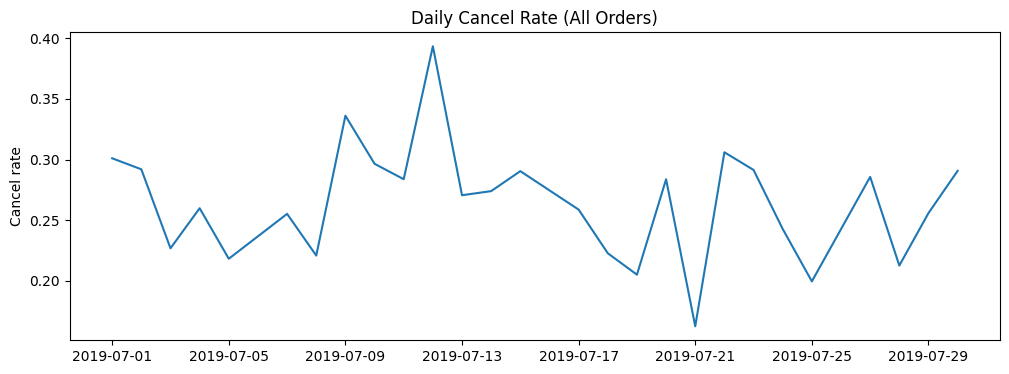

,dow,cancel_rate
0,Monday,0.274829
1,Tuesday,0.302545
2,Wednesday,0.256206
3,Thursday,0.241487
4,Friday,0.272229
5,Saturday,0.280013
6,Sunday,0.226081


In [7]:
# === 3D.1 Timeseries cancel rate theo ngày ===
orders["is_completed"] = orders["order_status"].eq("COMPLETED").astype(int)
orders["is_cancelled"] = orders["order_status"].eq("CANCELLED").astype(int)

by_day_all = (orders.groupby("created_day")
                     .agg(n_orders=("order_id","nunique"),
                          completed=("is_completed","sum"),
                          cancelled=("is_cancelled","sum"))
                     .reset_index())
by_day_all["cancel_rate"] = np.where(by_day_all["n_orders"]>0,
                                     by_day_all["cancelled"]/by_day_all["n_orders"], np.nan)

# Plot cancel rate
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(by_day_all["created_day"], by_day_all["cancel_rate"])
ax.set_title("Daily Cancel Rate (All Orders)")
ax.set_ylabel("Cancel rate")
plt.show()

# === 3D.2 Cancel rate by DOW ===
by_day_all["dow"] = by_day_all["created_day"].dt.day_name()
cancel_dow = (by_day_all.groupby("dow")["cancel_rate"].mean()
              .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
              .reset_index())
cancel_dow


In [8]:
# === 3D.3 Payment method mix theo DOW (All orders) ===
mix = (orders.groupby([orders["created_day"].dt.day_name(), "payment_method"])
              .size().reset_index(name="cnt"))
mix.rename(columns={"created_day":"dow"}, inplace=True)
mix["pct"] = mix.groupby("dow")["cnt"].transform(lambda x: x/x.sum())

# Top phương thức mỗi ngày
mix.sort_values(["dow","pct"], ascending=[True,False]).groupby("dow").head(3)


,dow,payment_method,cnt,pct
2,Friday,Cash on Delivery,28384,0.887638
0,Friday,Airpay GIRO,1344,0.042030
3,Friday,Cybersource,955,0.029865
27,Monday,Cash on Delivery,2995,0.850611
25,Monday,Airpay GIRO,190,0.053962
26,Monday,Airpay Wallet V2,103,0.029253
46,Saturday,Cash on Delivery,2858,0.858774
44,Saturday,Airpay GIRO,144,0.043269
47,Saturday,Cybersource,78,0.023438
65,Sunday,Cash on Delivery,4952,0.873677


In [9]:
# Completed July totals
month_rev = completed["line_revenue"].sum()
avg_daily = daily["revenue"].mean()
median_daily = daily["revenue"].median()

print("Completed Revenue July:", f"{month_rev:,.0f} VND")
print("Avg daily:", f"{avg_daily:,.0f} VND | Median daily:", f"{median_daily:,.0f} VND")

Completed Revenue July: 8,072,083,720 VND
Avg daily: 269,069,457 VND | Median daily: 131,589,330 VND


Event revenue share: 68.28 %
[saved] outputs_EVENT_AWARE/20250920-160043/event_flagged_daily_revenue.png


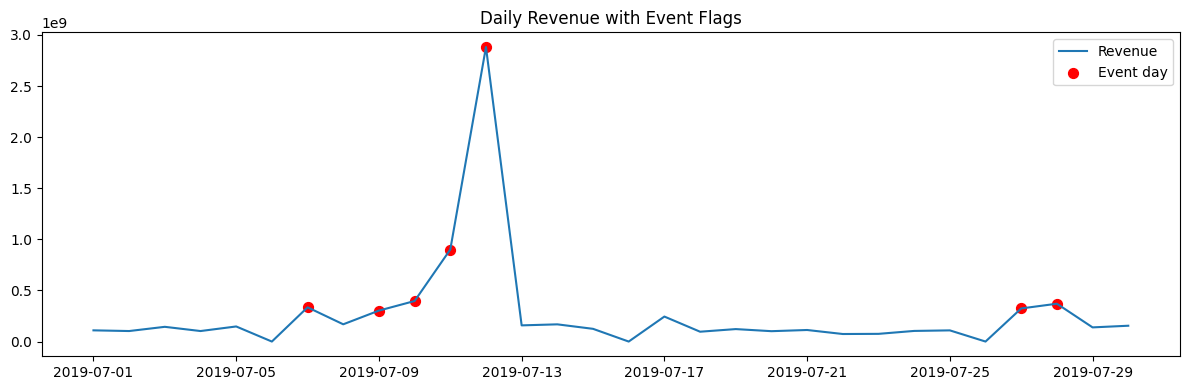

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_EVENT_AWARE/20250920-160043/daily_with_event_flags.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Yêu cầu: bạn đã có 'daily' (từ EDA Step 3) với cột ['created_day','revenue','orders']

import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_EVENT_AWARE/{TS}"
os.makedirs(OUT, exist_ok=True)

def savefig_and_download(fig, name, dpi=160):
    p = f"{OUT}/{name}.png"
    fig.tight_layout(); fig.savefig(p, dpi=dpi, bbox_inches="tight")
    print("[saved]", p); plt.show(); files.download(p)

def savecsv_and_download(df, name):
    p = f"{OUT}/{name}.csv"
    df.to_csv(p, index=False); print("[saved]", p); files.download(p)

# Robust-Z helper
def robust_z(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) or 1.0
    return (x - med) / (1.4826 * mad)

daily = daily.copy()
daily["rev_rz"] = robust_z(daily["revenue"].values)

# Ngưỡng “event”: |robust-Z| > 3 (có thể hạ còn 2.5 nếu muốn rộng hơn)
daily["is_event"] = daily["rev_rz"].abs() > 3

# Tỷ trọng doanh thu từ các ngày event
event_share = daily.loc[daily["is_event"], "revenue"].sum() / daily["revenue"].sum()
print("Event revenue share:", round(event_share*100,2), "%")

# Biểu đồ đánh dấu event
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(daily["created_day"], daily["revenue"], label="Revenue")
ax.scatter(daily.loc[daily["is_event"], "created_day"],
           daily.loc[daily["is_event"], "revenue"],
           color="red", s=50, label="Event day")
ax.set_title("Daily Revenue with Event Flags")
ax.legend()
savefig_and_download(fig, "event_flagged_daily_revenue")

savecsv_and_download(daily, "daily_with_event_flags")

Flagged super-event day(s):


,created_day,revenue,orders
11,2019-07-12,2881886000,12229


[saved] outputs_EVENT_TOP1/20250920-160457/daily_revenue_super_event_top1.png


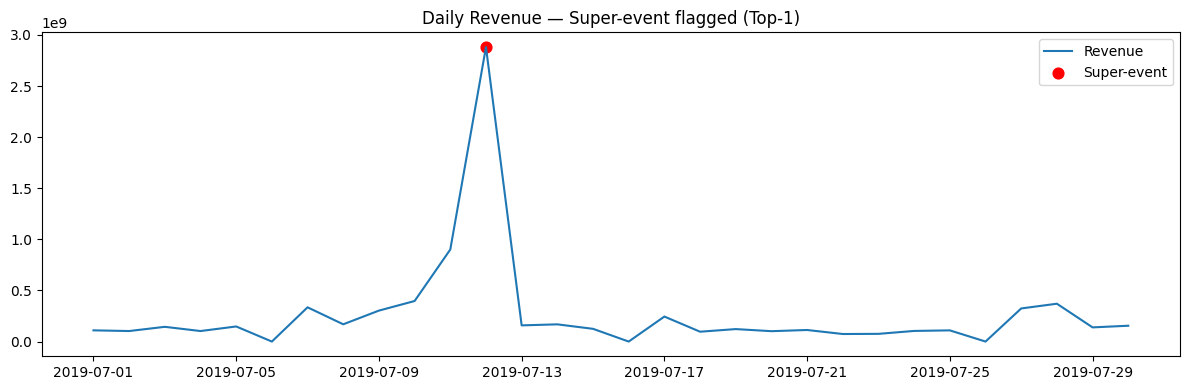

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_EVENT_TOP1/20250920-160457/daily_super_event_top1.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# === A) FLAG 1 SIÊU-EVENT ===
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_EVENT_TOP1/{TS}"
os.makedirs(OUT, exist_ok=True)

def savefig_and_download(fig, name, dpi=160):
    p = f"{OUT}/{name}.png"
    fig.tight_layout(); fig.savefig(p, dpi=dpi, bbox_inches="tight")
    print("[saved]", p); plt.show(); files.download(p)

def savecsv_and_download(df, name):
    p = f"{OUT}/{name}.csv"
    df.to_csv(p, index=False); print("[saved]", p); files.download(p)

# `daily` đã có từ EDA Step 3 (created_day, revenue, orders, aov...)
daily = daily.copy()

# CÁCH 1 (ưu tiên): flag top-1 theo revenue
topk = 1
idx_top = daily["revenue"].nlargest(topk).index
daily["is_event"] = False
daily.loc[idx_top, "is_event"] = True

# (Tùy chọn) CÁCH 2: chỉ định thủ công ngày siêu-event
# super_event_date = pd.Timestamp("2019-07-12")
# daily["is_event"] = daily["created_day"].eq(super_event_date)

# Kiểm tra: ngày nào được flag?
flagged = daily.loc[daily["is_event"], ["created_day","revenue","orders"]]
print("Flagged super-event day(s):")
display(flagged)

# Vẽ lại để xác nhận
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(daily["created_day"], daily["revenue"], label="Revenue")
ax.scatter(daily.loc[daily["is_event"], "created_day"],
           daily.loc[daily["is_event"], "revenue"],
           color="red", s=60, label="Super-event")
ax.set_title("Daily Revenue — Super-event flagged (Top-1)")
ax.legend()
savefig_and_download(fig, "daily_revenue_super_event_top1")

savecsv_and_download(daily, "daily_super_event_top1")


Training dates (no super-event): 2019-07-01 00:00:00 → 2019-07-30 00:00:00
Train rows: 29


DEBUG:cmdstanpy:input tempfile: /tmp/tmpwvnecf2p/3403fg4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwvnecf2p/tbytwtp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83787', 'data', 'file=/tmp/tmpwvnecf2p/3403fg4_.json', 'init=/tmp/tmpwvnecf2p/tbytwtp6.json', 'output', 'file=/tmp/tmpwvnecf2p/prophet_model_t12t3j1/prophet_model-20250920161143.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:11:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:11:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Baseline 30d (train exclude super-event): 4,384,354,220 VND
Gap to 20B: 15,615,645,780 VND
[saved] outputs_BASELINE_NO_EVENT/20250920-161140/forecast_no_super_event.png


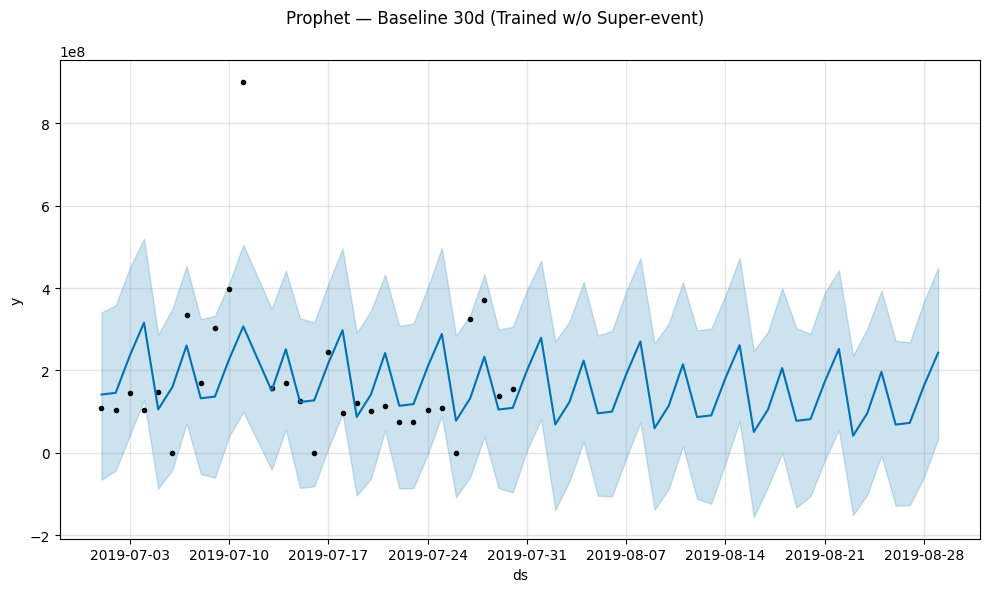

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_BASELINE_NO_EVENT/20250920-161140/forecast_components_no_super_event.png


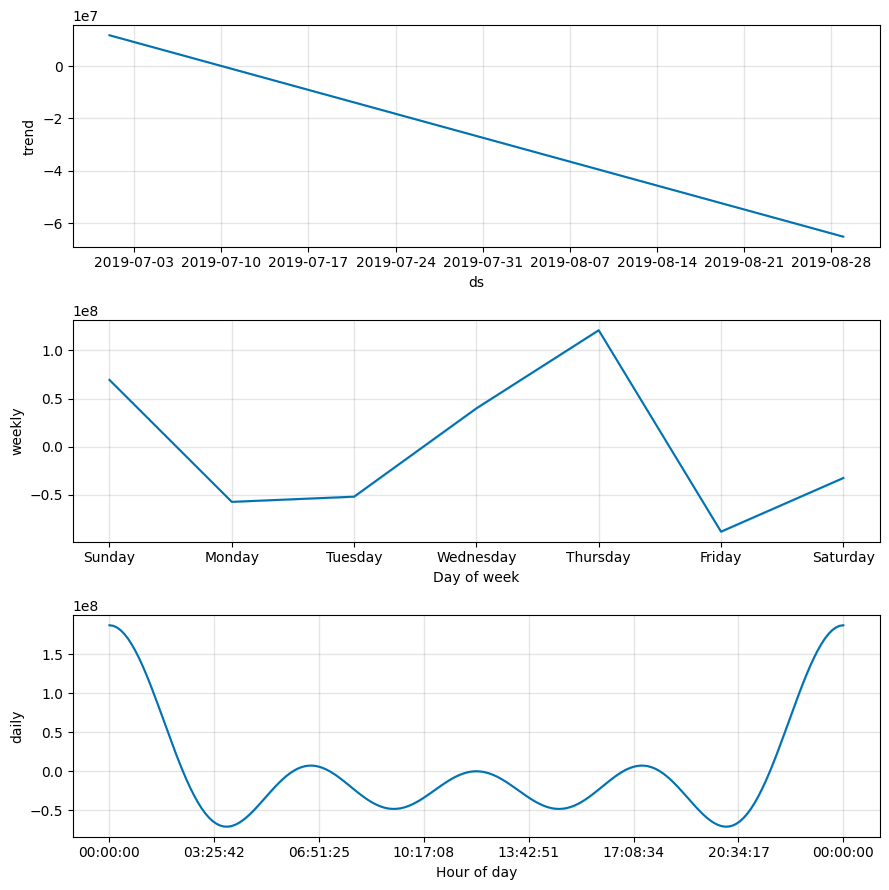

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_BASELINE_NO_EVENT/20250920-161140/forecast_table_no_super_event.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# === BASELINE 30D WITHOUT SUPER-EVENT ===
import os, time
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Yêu cầu: biến `daily` đã tồn tại và có cột is_event (bạn vừa flag Top-1)
assert 'daily' in globals(), "Run Step A to create `daily` with is_event first."
assert 'is_event' in daily.columns, "`daily` must contain is_event column."

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_BASELINE_NO_EVENT/{TS}"
os.makedirs(OUT, exist_ok=True)

def savefig_and_download(fig, name, dpi=160):
    p = f"{OUT}/{name}.png"
    fig.tight_layout()
    fig.savefig(p, dpi=dpi, bbox_inches="tight")
    print("[saved]", p)
    plt.show()
    try:
        files.download(p)
    except Exception as e:
        print("download skipped:", e)

def savecsv_and_download(df, name):
    p = f"{OUT}/{name}.csv"
    df.to_csv(p, index=False)
    print("[saved]", p)
    try:
        files.download(p)
    except Exception as e:
        print("download skipped:", e)

# 1) Chuẩn bị tập train: loại super-event
df_ne = (daily.loc[~daily['is_event'], ['created_day','revenue']]
               .rename(columns={'created_day':'ds','revenue':'y'})
               .sort_values('ds')
               .reset_index(drop=True))

print("Training dates (no super-event):", df_ne['ds'].min(), "→", df_ne['ds'].max())
print("Train rows:", len(df_ne))

# 2) Fit Prophet (không regressor, vì đã loại event khỏi train)
try:
    from prophet import Prophet
except:
    !pip install prophet --quiet
    from prophet import Prophet

n_chg = max(1, min(10, len(df_ne)//3))
m_ne = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    n_changepoints=n_chg,
    changepoint_prior_scale=0.05,
    interval_width=0.8
)
m_ne.fit(df_ne)

# 3) Forecast 30 ngày tới
future_ne = m_ne.make_future_dataframe(periods=30, freq='D')
fc_ne = m_ne.predict(future_ne)

# 4) Tổng baseline 30d & gap
base_30_ne = float(fc_ne.tail(30)['yhat'].sum())
gap_20b = 20_000_000_000 - base_30_ne
print("Baseline 30d (train exclude super-event):", f"{base_30_ne:,.0f} VND")
print("Gap to 20B:", f"{gap_20b:,.0f} VND")

# 5) Plot & export
fig1 = m_ne.plot(fc_ne)
fig1.suptitle("Prophet — Baseline 30d (Trained w/o Super-event)")
savefig_and_download(fig1, "forecast_no_super_event")

fig2 = m_ne.plot_components(fc_ne)
savefig_and_download(fig2, "forecast_components_no_super_event")

savecsv_and_download(fc_ne, "forecast_table_no_super_event")


In [13]:
# Kiểm tra có bao ngày đang is_event=True?
daily[['created_day','revenue','is_event']].sort_values('created_day')
print("Num event days flagged:", daily['is_event'].sum())
print("Flagged dates:", daily.loc[daily['is_event'], 'created_day'].dt.date.tolist())


Num event days flagged: 1
Flagged dates: [datetime.date(2019, 7, 12)]


Super-event date: 2019-07-12 00:00:00

=== Super-event uplift summary (VND) ===


,metric,value
0,event_revenue,2.881886e+09
1,counterfactual_yhat,9.607117e+07
2,baseline_median_non_event,1.245172e+08
3,uplift_vs_model,2.785815e+09
4,uplift_vs_median,2.757369e+09


[saved] outputs_EVENT_EFFECT/20250920-162049/super_event_decomposition.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_EVENT_EFFECT/20250920-162049/super_event_uplift_decomposition.png


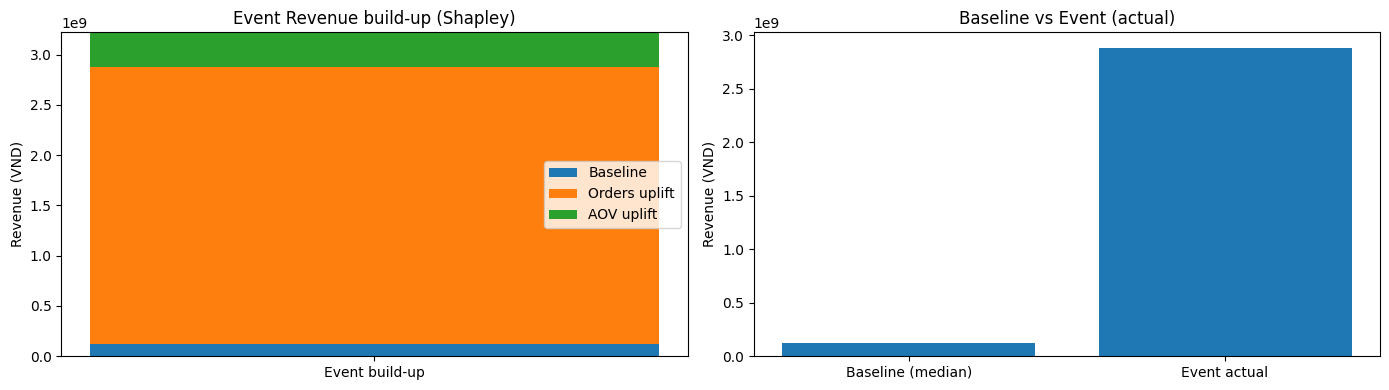

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_EVENT_EFFECT/20250920-162049/super_event_uplift_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# === C1) QUANTIFY SUPER-EVENT UPLIFT ===
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files

assert 'daily' in globals() and 'm_ne' in globals(), "Hãy chạy các bước A/B trước để có `daily` và `m_ne`."

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_EVENT_EFFECT/{TS}"
os.makedirs(OUT, exist_ok=True)

def savefig_and_download(fig, name, dpi=160):
    p = f"{OUT}/{name}.png"
    fig.tight_layout(); fig.savefig(p, dpi=dpi, bbox_inches="tight")
    print("[saved]", p); plt.show();
    try: files.download(p)
    except Exception as e: print("download skipped:", e)

def savecsv_and_download(df, name):
    p = f"{OUT}/{name}.csv"
    df.to_csv(p, index=False); print("[saved]", p)
    try: files.download(p)
    except Exception as e: print("download skipped:", e)

# 1) Lấy ngày super-event
evt_date = daily.loc[daily["is_event"], "created_day"].iloc[0]
print("Super-event date:", evt_date)

# 2) Counterfactual theo model (predict cho toàn dải ngày để lấy yhat của 12/07)
df_ds = pd.DataFrame({"ds": pd.date_range(daily["created_day"].min(), daily["created_day"].max(), freq="D")})
fc_in = m_ne.predict(df_ds)   # model train exclude event -> dự đoán cho 12/07 = baseline no-event
yhat_evt = float(fc_in.loc[fc_in["ds"]==evt_date, "yhat"].values[0])

# 3) Số liệu thực tế của ngày event (Completed only)
row_evt = daily.loc[daily["created_day"]==evt_date].iloc[0]
R_e, O_e, AOV_e = float(row_evt["revenue"]), float(row_evt["orders"]), float(row_evt.get("aov", row_evt["revenue"]/max(1,row_evt["orders"])))

# 4) Baseline robust theo median non-event
non_event = daily[~daily["is_event"]].copy()
R_b_med = float(non_event["revenue"].median())
O_b_med = float(non_event["orders"].median())
AOV_b_med = float(non_event["aov"].median())

# 5) Uplift theo 2 cách
uplift_model = R_e - yhat_evt
uplift_median = R_e - R_b_med

summary = pd.DataFrame({
    "metric": ["event_revenue", "counterfactual_yhat", "baseline_median_non_event", "uplift_vs_model", "uplift_vs_median"],
    "value": [R_e, yhat_evt, R_b_med, uplift_model, uplift_median]
})
print("\n=== Super-event uplift summary (VND) ===")
display(summary)

# 6) Shapley decomposition (dùng baseline median non-event cho Orders/AOV)
contrib_orders = (O_e - O_b_med) * ((AOV_e + AOV_b_med)/2.0)
contrib_aov    = (AOV_e - AOV_b_med) * ((O_e   + O_b_med)/2.0)
remainder = (R_e - (R_b_med + contrib_orders + contrib_aov))  # sai số nhỏ do làm tròn/robust

decomp = pd.DataFrame({
    "component": ["Baseline (median non-event)", "Orders uplift (Shapley)", "AOV uplift (Shapley)", "Residual"],
    "value": [R_b_med, contrib_orders, contrib_aov, remainder]
})
savecsv_and_download(decomp, "super_event_decomposition")

# 7) Visual: baseline vs event + stacked contributions
fig, axes = plt.subplots(1, 2, figsize=(14,4))

# Left: Stacked contributions build-up
axes[0].bar(["Event build-up"], [R_b_med], label="Baseline")
axes[0].bar(["Event build-up"], [contrib_orders], bottom=[R_b_med], label="Orders uplift")
axes[0].bar(["Event build-up"], [contrib_aov], bottom=[R_b_med+contrib_orders], label="AOV uplift")
axes[0].set_title("Event Revenue build-up (Shapley)")
axes[0].set_ylabel("Revenue (VND)")
axes[0].legend()

# Right: Baseline vs Event
axes[1].bar(["Baseline (median)","Event actual"], [R_b_med, R_e])
axes[1].set_title("Baseline vs Event (actual)")
axes[1].set_ylabel("Revenue (VND)")

savefig_and_download(fig, "super_event_uplift_decomposition")

# 8) Lưu summary CSV
out = pd.DataFrame({
    "evt_date":[evt_date],
    "R_event":[R_e],
    "yhat_counterfactual":[yhat_evt],
    "uplift_vs_model":[uplift_model],
    "R_baseline_median":[R_b_med],
    "uplift_vs_median":[uplift_median],
    "orders_event":[O_e],
    "orders_baseline_median":[O_b_med],
    "aov_event":[AOV_e],
    "aov_baseline_median":[AOV_b_med],
})
savecsv_and_download(out, "super_event_uplift_summary")


Baseline 30d (no event): 4,384,354,220 VND
Uplift per super-event (vs model CF): 2,785,814,826 VND
Super-events needed to reach 20B: 6


,super_events,revenue_30d,gap_to_20B
0,0,4384354220,15615645780
1,1,7170169045,12829830955
2,2,9955983871,10044016129
3,3,12741798696,7258201304
4,4,15527613522,4472386478
5,5,18313428348,1686571652
6,6,21099243173,-1099243173


[saved] outputs_SCENARIO/20250920-162541/scenario_super_event_counts.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_SCENARIO/20250920-162541/scenario_super_event_bar.png


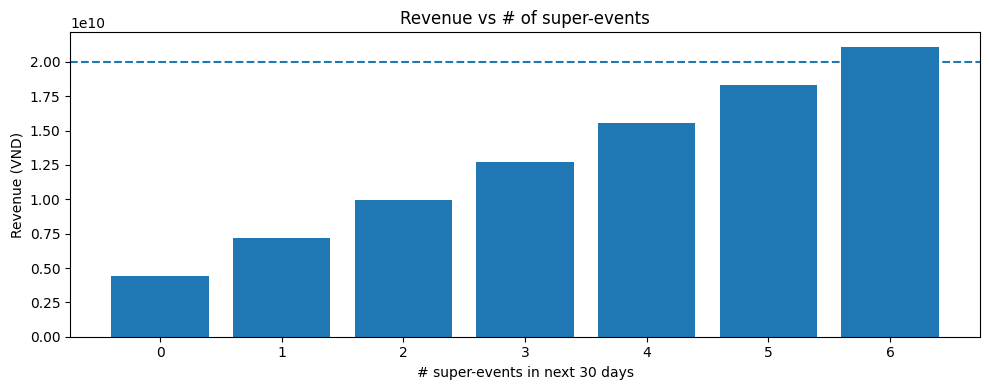

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# === C2) SCENARIO: số siêu-event cần để đạt 20B ===
import math, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
import os, time

# Yêu cầu: bạn đã chạy Step B (có base_30_ne) và C1 (có uplift_model)
assert 'base_30_ne' in globals(), "Need `base_30_ne` from Step B."
assert 'uplift_model' in globals(), "Need `uplift_model` from Step C1."

TARGET = 20_000_000_000
uplift_event = float(uplift_model)
base_30 = float(base_30_ne)

n_needed = max(0, math.ceil((TARGET - base_30) / max(1.0, uplift_event)))
print(f"Baseline 30d (no event): {base_30:,.0f} VND")
print(f"Uplift per super-event (vs model CF): {uplift_event:,.0f} VND")
print(f"Super-events needed to reach 20B: {n_needed}")

# Bảng scenario 0..max(n_needed, 3)
rows = []
for k in range(0, max(n_needed, 3) + 1):
    rev = base_30 + k * uplift_event
    gap = TARGET - rev
    rows.append({"super_events": k, "revenue_30d": round(rev), "gap_to_20B": round(gap)})
scen = pd.DataFrame(rows)
display(scen)

# Lưu + tải
TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_SCENARIO/{TS}"; os.makedirs(OUT, exist_ok=True)
scen_path = f"{OUT}/scenario_super_event_counts.csv"; scen.to_csv(scen_path, index=False)
print("[saved]", scen_path); files.download(scen_path)

# Plot
fig, ax = plt.subplots(figsize=(10,4))
ax.bar(scen["super_events"].astype(str), scen["revenue_30d"])
ax.axhline(TARGET, linestyle="--")
ax.set_title("Revenue vs # of super-events")
ax.set_xlabel("# super-events in next 30 days")
ax.set_ylabel("Revenue (VND)")
plot_path = f"{OUT}/scenario_super_event_bar.png"
fig.tight_layout(); fig.savefig(plot_path, dpi=160, bbox_inches="tight")
print("[saved]", plot_path); plt.show(); files.download(plot_path)


In [16]:
# 1) GA totals (sau khi đã có traffic_clean)
ga_rev = traffic_clean["Revenue"].sum()

# 2) Orders totals
orders = orders.copy()
orders["line_revenue"] = orders["item_quantity"] * orders["selling_price"]

placed_all = orders["line_revenue"].sum()  # tất cả trạng thái
placed_completed = orders.loc[orders["order_status"]=="COMPLETED","line_revenue"].sum()
placed_cancelled = orders.loc[orders["order_status"]=="CANCELLED","line_revenue"].sum()

# (tuỳ mô hình kế toán) shipping có thể làm lệch giữa GA và OMS
ship_all = orders["shipping_fee"].sum()
ship_completed = orders.loc[orders["order_status"]=="COMPLETED","shipping_fee"].sum()

print(f"GA Revenue (no GRAND TOTAL): {ga_rev:,.0f}")
print(f"Placed (all statuses) product revenue: {placed_all:,.0f}")
print(f"  ├─ Completed product revenue:       {placed_completed:,.0f}")
print(f"  └─ Cancelled product revenue:       {placed_cancelled:,.0f}")
print(f"Shipping fee (all): {ship_all:,.0f} | Shipping fee (completed): {ship_completed:,.0f}")

# Gợi ý so sánh:
# GA ≈ Placed_all (+/- shipping cấu hình)  ; Completed < Placed_all do có CANCELLED


GA Revenue (no GRAND TOTAL): 10,006,473,136
Placed (all statuses) product revenue: 10,065,855,170
  ├─ Completed product revenue:       8,072,083,720
  └─ Cancelled product revenue:       1,993,771,450
Shipping fee (all): 690,804,572 | Shipping fee (completed): 508,978,481


In [17]:
# === PLAN PARAMETERS ===
BASELINE_30D = 4_384_354_220  # từ Step B (train exclude super-event)
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220  # lấy từ bảng scenario C2 của bạn
N_EVENTS = 3
TARGET = 20_000_000_000

plan_revenue = BASELINE_30D + N_EVENTS * UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)

print(f"Baseline 30d (no event)   : {BASELINE_30D:,.0f} VND")
print(f"Uplift per super-event    : {UPLIFT_PER_EVENT:,.0f} VND")
print(f"Plan B (3 events) revenue : {plan_revenue:,.0f} VND")
print(f"Residual GAP to 20B       : {residual_gap:,.0f} VND")


Baseline 30d (no event)   : 4,384,354,220 VND
Uplift per super-event    : 2,785,814,825 VND
Plan B (3 events) revenue : 12,741,798,695 VND
Residual GAP to 20B       : 7,258,201,305 VND


In [18]:
# === CHANNEL DIAGNOSIS (SCALE / FIX / PAUSE) ===
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from statsmodels.stats.proportion import proportions_ztest

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_ATTRIB_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)

def savecsv(df,name):
    p=f"{OUT}/{name}.csv"; df.to_csv(p,index=False); print("[saved]",p); files.download(p)

# 1) Chuẩn hoá GA data (đảm bảo đã drop GRAND TOTAL)
t = traffic_clean.rename(columns={
    "Source / Medium":"source_medium",
    "Bounce Rate":"bounce_rate",
    "Pages / Session":"pages_per_session",
    "Avg. Session Duration":"avg_session_duration",
    "Ecommerce Conversion Rate":"cvr"
}).copy()
t["cvr"] = t["cvr"].astype(float)
t["rps"] = np.where(t["Sessions"]>0, t["Revenue"]/t["Sessions"], np.nan)
t["aov_proxy"] = np.where(t["Transactions"]>0, t["Revenue"]/t["Transactions"], np.nan)

# 2) Giữ kênh có quy mô đủ lớn (≥0.5% tổng sessions)
min_sessions = 0.005 * t["Sessions"].sum()
tb = t.loc[t["Sessions"] >= min_sessions].copy()

overall_sessions = tb["Sessions"].sum()
overall_trans = tb["Transactions"].sum()
overall_rev = tb["Revenue"].sum()
overall_cvr = overall_trans/overall_sessions if overall_sessions>0 else np.nan
overall_rps_med = tb["rps"].median()
overall_bounce_med = tb["bounce_rate"].median()

rows=[]
for _, r in tb.iterrows():
    s, tr = r["Sessions"], r["Transactions"]
    rest_s = overall_sessions - s
    rest_tr = overall_trans - tr
    if s>0 and rest_s>0:
        zstat, p_cvr = proportions_ztest([tr, rest_tr], [s, rest_s])
    else:
        p_cvr = np.nan
    rows.append({
        "source_medium": r["source_medium"],
        "sessions": int(s),
        "transactions": int(tr),
        "revenue": float(r["Revenue"]),
        "cvr": float(r["cvr"]),
        "aov_proxy": float(r["aov_proxy"]),
        "rps": float(r["rps"]),
        "bounce_rate": float(r["bounce_rate"]),
        "p_cvr_vs_rest": float(p_cvr) if p_cvr==p_cvr else np.nan
    })
diag = pd.DataFrame(rows)

# 3) Rule gán nhãn
cvr_med = diag["cvr"].median()
rps_med = diag["rps"].median()
bounce_med = diag["bounce_rate"].median()

def decide(row):
    good_cvr = (row["p_cvr_vs_rest"] < 0.05) and (row["cvr"] >= cvr_med)
    good_rps = row["rps"] >= rps_med
    low_bounce = row["bounce_rate"] <= bounce_med
    if good_cvr and good_rps and low_bounce:
        return "SCALE"
    if (row["sessions"] >= diag["sessions"].median()) and (not good_rps or row["cvr"] < cvr_med):
        return "FIX"
    return "PAUSE"

diag["action"] = diag.apply(decide, axis=1)
diag = diag.sort_values(["action","rps"], ascending=[True,False])
savecsv(diag, "channel_diagnosis_actions")
diag.head(10)


[saved] outputs_ATTRIB_PLANB/20250920-172630/channel_diagnosis_actions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,source_medium,sessions,transactions,revenue,cvr,aov_proxy,rps,bounce_rate,p_cvr_vs_rest,action
1,youtube / social,163447,957,8.429079e+08,0.005855,8.807815e+05,5157.071932,0.788115,5.978925e-24,FIX
3,facebook / social,176662,500,5.344857e+08,0.002830,1.068971e+06,3025.470595,0.844002,1.325845e-149,FIX
5,m.facebook.com / referral,17631,127,1.141888e+08,0.007203,8.991243e+05,6476.591484,0.699733,2.818870e-01,PAUSE
6,l.facebook.com / referral,7144,103,1.508016e+08,0.014418,1.464094e+06,21108.852482,0.370521,5.013603e-10,SCALE
2,(direct) / (none),108534,1048,1.040851e+09,0.009656,9.931789e+05,9590.095701,0.553264,1.283580e-11,SCALE
4,youtube.com / referral,42464,508,4.025419e+08,0.011963,7.924053e+05,9479.604249,0.639224,1.014560e-21,SCALE
0,google / cpc,723208,6566,6.656088e+09,0.009079,1.013720e+06,9203.559866,0.621901,5.423674e-67,SCALE


[saved] outputs_ATTRIB_FULL/20250920-175245/channel_diagnosis_FULL_all_sources.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_ATTRIB_FULL/20250920-175245/channel_diagnosis_SHORTLIST_ge_0_5pct.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_ATTRIB_FULL/20250920-175245/diagnosis_summary_by_action.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_ATTRIB_FULL/20250920-175245/pareto_sessions_coverage.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

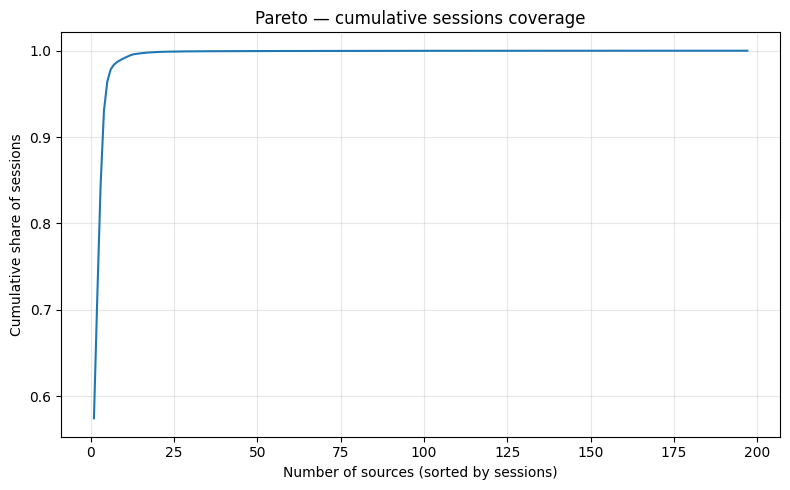

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
# === CHANNEL DIAGNOSIS — FULL (all sources) + SHORTLIST (>=0.5%) ===
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from google.colab import files

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_ATTRIB_FULL/{TS}"; os.makedirs(OUT, exist_ok=True)

def savecsv(df, name):
    p = f"{OUT}/{name}.csv"; df.to_csv(p, index=False)
    print("[saved]", p); files.download(p)

# 0) Load GA traffic (ưu tiên biến traffic_clean; fallback đọc Excel & drop GRAND TOTAL)
try:
    t = traffic_clean.copy()
except NameError:
    raw = pd.read_excel("Sample_Customore_Traffic raw.xlsx")
    t = raw.iloc[:-1].copy()  # bỏ dòng Grand Total

# 1) Chuẩn hóa cột & ép kiểu
t = t.rename(columns={
    "Source / Medium":"source_medium",
    "Bounce Rate":"bounce_rate",
    "Pages / Session":"pages_per_session",
    "Avg. Session Duration":"avg_session_duration",
    "Ecommerce Conversion Rate":"cvr"
})
for col in ["Sessions","Transactions","Revenue","cvr","bounce_rate",
            "pages_per_session","avg_session_duration"]:
    if col in t.columns:
        t[col] = pd.to_numeric(t[col], errors="coerce")

# 2) Tính các chỉ số funnel
t["rps"] = np.where(t["Sessions"]>0, t["Revenue"]/t["Sessions"], np.nan)            # Revenue per Session
t["aov_proxy"] = np.where(t["Transactions"]>0, t["Revenue"]/t["Transactions"], np.nan)

total_sessions = t["Sessions"].sum(skipna=True)
total_trans    = t["Transactions"].sum(skipna=True)

# 3) CVR test vs. rest cho MỌI nguồn (không lọc)
rows = []
for _, r in t.iterrows():
    s  = float(r["Sessions"]) if pd.notna(r["Sessions"]) else 0.0
    tr = float(r["Transactions"]) if pd.notna(r["Transactions"]) else 0.0
    rest_s, rest_tr = total_sessions - s, total_trans - tr
    if s>0 and rest_s>0:
        _, pval = proportions_ztest([tr, rest_tr], [s, rest_s])
        p_cvr = float(pval)
    else:
        p_cvr = np.nan
    rows.append({
        "source_medium": r["source_medium"],
        "sessions": int(s) if np.isfinite(s) else 0,
        "transactions": int(tr) if np.isfinite(tr) else 0,
        "revenue": float(r["Revenue"]) if pd.notna(r["Revenue"]) else np.nan,
        "cvr": float(r["cvr"]) if pd.notna(r["cvr"]) else np.nan,
        "aov_proxy": float(r["aov_proxy"]) if pd.notna(r["aov_proxy"]) else np.nan,
        "rps": float(r["rps"]) if pd.notna(r["rps"]) else np.nan,
        "bounce_rate": float(r["bounce_rate"]) if pd.notna(r["bounce_rate"]) else np.nan,
        "p_cvr_vs_rest": p_cvr,
        "sessions_share": (s/total_sessions) if total_sessions>0 else np.nan,
        "low_sample_flag": (s<1000) or (tr<20)  # gắn cờ mẫu nhỏ để stakeholder hiểu độ tin cậy
    })
diag = pd.DataFrame(rows)

# 4) Gán nhãn SCALE / FIX / PAUSE + lý do
cvr_med     = diag["cvr"].median(skipna=True)
rps_med     = diag["rps"].median(skipna=True)
bounce_med  = diag["bounce_rate"].median(skipna=True)
sess_med    = diag["sessions"].median(skipna=True)

def decide(row):
    reasons = []
    good_cvr   = (pd.notna(row["p_cvr_vs_rest"]) and row["p_cvr_vs_rest"]<0.05 and pd.notna(row["cvr"]) and row["cvr"]>=cvr_med)
    good_rps   = (pd.notna(row["rps"]) and row["rps"]>=rps_med)
    low_bounce = (pd.notna(row["bounce_rate"]) and row["bounce_rate"]<=bounce_med)

    if good_cvr and good_rps and low_bounce:
        action = "SCALE"; reasons.append("CVR tốt (p<0.05) · RPS≥median · Bounce≤median")
    elif (pd.notna(row["sessions"]) and row["sessions"]>=sess_med) and ( (not good_rps) or (pd.notna(row["cvr"]) and row["cvr"]<cvr_med) ):
        action = "FIX";   reasons.append("Quy mô lớn nhưng CVR/RPS chưa đạt")
    else:
        action = "PAUSE"; reasons.append("Hiệu quả thấp hoặc quy mô nhỏ")

    if row["low_sample_flag"]:
        reasons.append("⚠️ mẫu nhỏ (sessions<1000 hoặc trans<20)")

    return pd.Series({"action": action, "reason": " ; ".join(reasons)})

diag[["action","reason"]] = diag.apply(decide, axis=1)

# 5) Sắp xếp & lưu FULL LANDSCAPE (mọi nguồn)
priority = {"SCALE":1,"FIX":2,"PAUSE":3}
diag["priority"] = diag["action"].map(priority)
diag_full = diag.sort_values(["priority","rps"], ascending=[True,False]).reset_index(drop=True)
savecsv(diag_full, "channel_diagnosis_FULL_all_sources")

# 6) Lọc SHORTLIST ≥0.5% sessions (cho action/budget)
short = diag_full.loc[diag_full["sessions_share"]>=0.005].copy()
savecsv(short, "channel_diagnosis_SHORTLIST_ge_0_5pct")

# 7) Summary theo action (để slide cho stakeholder)
summary = (diag_full.groupby("action", as_index=False)
           .agg(sources=("source_medium","count"),
                sessions=("sessions","sum"),
                transactions=("transactions","sum"),
                revenue=("revenue","sum"),
                sessions_share=("sessions_share","sum"),
                mean_cvr=("cvr","mean"),
                mean_rps=("rps","mean")))
summary["sessions_share"] = summary["sessions_share"].round(4)
savecsv(summary, "diagnosis_summary_by_action")

# 8) Pareto coverage of sessions (giải thích vì sao shortlist đủ)
pareto = diag_full[["source_medium","sessions"]].sort_values("sessions", ascending=False).copy()
pareto["cum_sessions"] = pareto["sessions"].cumsum()
pareto["cum_share"] = pareto["cum_sessions"]/total_sessions
pareto.to_csv(f"{OUT}/pareto_sessions_coverage.csv", index=False); print("[saved]", f"{OUT}/pareto_sessions_coverage.csv"); files.download(f"{OUT}/pareto_sessions_coverage.csv")

# Plot Pareto
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pareto)+1), pareto["cum_share"])
plt.title("Pareto — cumulative sessions coverage")
plt.xlabel("Number of sources (sorted by sessions)")
plt.ylabel("Cumulative share of sessions")
plt.grid(True, alpha=.3)
plt.tight_layout()
plt.savefig(f"{OUT}/pareto_sessions_coverage.png", dpi=160, bbox_inches="tight")
plt.show()
files.download(f"{OUT}/pareto_sessions_coverage.png")


In [20]:
# === 3A. Plan B params + Sessions Needed per channel ===
import pandas as pd, numpy as np, os, time, glob
from google.colab import files

# 1) Nạp file chẩn đoán mới nhất (FULL và SHORTLIST)
diag_full_path  = sorted(glob.glob("outputs_ATTRIB_FULL/*/channel_diagnosis_FULL_all_sources.csv"))[-1]
diag_short_path = sorted(glob.glob("outputs_ATTRIB_FULL/*/channel_diagnosis_SHORTLIST_ge_0_5pct.csv"))[-1]
diag_full  = pd.read_csv(diag_full_path)
diag_short = pd.read_csv(diag_short_path)

# 2) Tham số Plan B = 3 super-events (đã chốt)
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220  # = 2,785,814,825
N_EVENTS = 3
TARGET = 20_000_000_000

plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)

print(f"Plan B revenue: {plan_revenue:,.0f} | Residual GAP: {residual_gap:,.0f}")

def add_sessions_needed(df):
    df = df.copy()
    df["effective_rps"] = df["cvr"] * df["aov_proxy"]           # RPS = CVR × AOV
    df.loc[(df["effective_rps"]<=0) | (~np.isfinite(df["effective_rps"])),"effective_rps"] = np.nan
    df["sessions_needed_if_solo"] = residual_gap / df["effective_rps"]
    pr = {"SCALE":1,"FIX":2,"PAUSE":3}
    df["priority"] = df["action"].map(pr).fillna(4)
    return df.sort_values(["priority","sessions_needed_if_solo"], ascending=[True,True])

short_need = add_sessions_needed(diag_short)
full_need  = add_sessions_needed(diag_full)

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)

short_need.to_csv(f"{OUT}/planB_sessions_needed_SHORTLIST.csv", index=False)
full_need.to_csv(f"{OUT}/planB_sessions_needed_FULL.csv", index=False)
print("[saved]", f"{OUT}/planB_sessions_needed_SHORTLIST.csv")
print("[saved]", f"{OUT}/planB_sessions_needed_FULL.csv")
files.download(f"{OUT}/planB_sessions_needed_SHORTLIST.csv")
files.download(f"{OUT}/planB_sessions_needed_FULL.csv")

short_need.head(10)


Plan B revenue: 12,741,798,695 | Residual GAP: 7,258,201,305
[saved] outputs_PLANB/20250920-175815/planB_sessions_needed_SHORTLIST.csv
[saved] outputs_PLANB/20250920-175815/planB_sessions_needed_FULL.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,source_medium,sessions,transactions,revenue,cvr,aov_proxy,rps,bounce_rate,p_cvr_vs_rest,sessions_share,low_sample_flag,action,reason,priority,effective_rps,sessions_needed_if_solo
0,l.facebook.com / referral,7144,103,1.508016e+08,0.014418,1.464094e+06,21108.852482,0.370521,8.097122e-10,0.005672,False,SCALE,CVR tốt (p<0.05) · RPS≥median · Bounce≤median,1,21108.852482,3.438463e+05
1,(direct) / (none),108534,1048,1.040851e+09,0.009656,9.931789e+05,9590.095701,0.553264,6.861426e-11,0.086176,False,SCALE,CVR tốt (p<0.05) · RPS≥median · Bounce≤median,1,9590.095701,7.568435e+05
2,youtube.com / referral,42464,508,4.025419e+08,0.011963,7.924053e+05,9479.604249,0.639224,5.124759e-21,0.033716,False,PAUSE,Hiệu quả thấp hoặc quy mô nhỏ,3,9479.604249,7.656650e+05
3,google / cpc,723208,6566,6.656088e+09,0.009079,1.013720e+06,9203.559866,0.621901,3.933312e-59,0.574224,False,PAUSE,Hiệu quả thấp hoặc quy mô nhỏ,3,9203.559866,7.886298e+05
4,m.facebook.com / referral,17631,127,1.141888e+08,0.007203,8.991243e+05,6476.591484,0.699733,2.473824e-01,0.013999,False,PAUSE,Hiệu quả thấp hoặc quy mô nhỏ,3,6476.591484,1.120682e+06
5,youtube / social,163447,957,8.429079e+08,0.005855,8.807815e+05,5157.071932,0.788115,5.810869e-25,0.129776,False,PAUSE,Hiệu quả thấp hoặc quy mô nhỏ,3,5157.071932,1.407427e+06
6,facebook / social,176662,500,5.344857e+08,0.002830,1.068971e+06,3025.470595,0.844002,1.989584e-151,0.140269,False,PAUSE,Hiệu quả thấp hoặc quy mô nhỏ,3,3025.470595,2.399032e+06


In [21]:
# === 3B. Greedy allocation with per-channel CAP ===
import numpy as np, pandas as pd
from google.colab import files

ALLOC_ACTIONS = ["SCALE","FIX"]  # chỉ phân bổ cho SCALE trước, còn thiếu mới sang FIX
MAX_SCALE = 3                  # cap: tối đa 3× sessions hiện tại/kênh

alloc_base = short_need[short_need["action"].isin(ALLOC_ACTIONS)].copy()

remain = residual_gap
rows=[]
for _, r in alloc_base.iterrows():
    if not np.isfinite(r["effective_rps"]) or r["effective_rps"]<=0:
        continue
    max_sessions_cap = r["sessions"] * MAX_SCALE
    max_rev_cap = max_sessions_cap * r["effective_rps"]
    take_rev = min(max_rev_cap, remain)
    take_sessions = take_rev / r["effective_rps"]
    rows.append({
        "source_medium": r["source_medium"],
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"],
        "effective_rps": r["effective_rps"],
        "max_sessions_cap": int(round(max_sessions_cap)),
        "sessions_add_allocated": int(round(take_sessions)),
        "revenue_add_allocated": float(take_rev)
    })
    remain -= take_rev
    if remain <= 0: break

alloc_df = pd.DataFrame(rows)
alloc_df.to_csv(f"{OUT}/allocation_plan_capped.csv", index=False)
print("[saved]", f"{OUT}/allocation_plan_capped.csv"); files.download(f"{OUT}/allocation_plan_capped.csv")
print("Residual GAP after allocation (with caps):", f"{max(0,remain):,.0f} VND")
alloc_df


[saved] outputs_PLANB/20250920-175815/allocation_plan_capped.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual GAP after allocation (with caps): 3,683,242,038 VND


,source_medium,action,current_sessions,cvr,aov_proxy,effective_rps,max_sessions_cap,sessions_add_allocated,revenue_add_allocated
0,l.facebook.com / referral,SCALE,7144,0.014418,1.464094e+06,21108.852482,21432,21432,4.524049e+08
1,(direct) / (none),SCALE,108534,0.009656,9.931789e+05,9590.095701,325602,325602,3.122554e+09


In [22]:
# === REALLOCATE on FULL (SCALE -> FIX -> PAUSE) to close remaining GAP ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# 1) Nạp sessions-needed (FULL)
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# 2) Lấy residual hiện tại (giống bạn đang thấy ~3.68B)
#    Để chính xác, bạn có thể đọc từ plan_summary hoặc tính lại nhanh:
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap_initial = max(0, TARGET - plan_revenue)

# Nếu bạn đã có phân bổ trước 2 kênh (file allocation_plan_capped.csv), trừ phần đã phân bổ đi:
prev_alloc_path = sorted(glob.glob("outputs_PLANB/*/allocation_plan_capped.csv"))[-1]
prev_alloc = pd.read_csv(prev_alloc_path)
residual_gap = residual_gap_initial - prev_alloc["revenue_add_allocated"].sum()
residual_gap = max(0.0, residual_gap)
print(f"Residual GAP to cover (after previous allocation): {residual_gap:,.0f} VND")

# 3) Thiết lập phân bổ trên FULL: ưu tiên SCALE -> FIX -> PAUSE
priority = {"SCALE":1, "FIX":2, "PAUSE":3}
full_need["priority"] = full_need["action"].map(priority).fillna(4)

ALLOC_ACTIONS = ["SCALE","FIX","PAUSE"]  # cho phép cả PAUSE (xếp sau)
MAX_SCALE = 2.5                          # bạn có thể tăng lên 3.0–3.5 nếu cần

alloc_base = (full_need[full_need["action"].isin(ALLOC_ACTIONS)]
              .sort_values(["priority","sessions_needed_if_solo"], ascending=[True,True])
              .reset_index(drop=True))

rows=[]
remain = residual_gap
for _, r in alloc_base.iterrows():
    if not np.isfinite(r["effective_rps"]) or r["effective_rps"]<=0:
        continue
    max_sessions_cap = r["sessions"] * MAX_SCALE
    potential_rev = max_sessions_cap * r["effective_rps"]
    take_rev = min(potential_rev, remain)
    take_sessions = take_rev / r["effective_rps"]
    rows.append({
        "source_medium": r["source_medium"],
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"],
        "effective_rps": r["effective_rps"],
        "max_sessions_cap": int(round(max_sessions_cap)),
        "sessions_add_allocated": int(round(take_sessions)),
        "revenue_add_allocated": float(take_rev),
        "note": "FULL realocation pass"
    })
    remain -= take_rev
    if remain <= 0:
        break

add_alloc = pd.DataFrame(rows)

# 4) Hợp nhất với phân bổ trước (nếu muốn một file tổng)
combined = pd.concat([prev_alloc, add_alloc], ignore_index=True)
TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)

combined.to_csv(f"{OUT}/allocation_plan_capped_FULLpass.csv", index=False)
print("[saved]", f"{OUT}/allocation_plan_capped_FULLpass.csv")
files.download(f"{OUT}/allocation_plan_capped_FULLpass.csv")

print("Residual after FULL-pass allocation:", f"{max(0.0,remain):,.0f} VND")
display(add_alloc.head(10))


Residual GAP to cover (after previous allocation): 3,683,242,038 VND
[saved] outputs_PLANB/20250920-180351/allocation_plan_capped_FULLpass.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after FULL-pass allocation: 0 VND


,source_medium,action,current_sessions,cvr,aov_proxy,effective_rps,max_sessions_cap,sessions_add_allocated,revenue_add_allocated,note
0,getpocket.com / local_display,SCALE,8,0.125000,6.401055e+05,80013.188886,20,20,1.600264e+06,FULL realocation pass
1,l.messenger.com / local_display,SCALE,264,0.037879,1.230573e+06,46612.600432,660,660,3.076432e+07,FULL realocation pass
2,newsletter / email,SCALE,2168,0.028137,1.621488e+06,45623.060156,5420,5420,2.472770e+08,FULL realocation pass
3,news.zing.vn / local_display,SCALE,14,0.071429,5.676407e+05,40545.766875,35,35,1.419102e+06,FULL realocation pass
4,vnexpress.net / local_display,SCALE,105,0.028571,1.413063e+06,40373.231697,262,262,1.059797e+07,FULL realocation pass
5,newsletter / email,SCALE,662,0.033233,7.604410e+05,25271.451689,1655,1655,4.182425e+07,FULL realocation pass
6,l.facebook.com / referral,SCALE,7144,0.014418,1.464094e+06,21108.852482,17860,17860,3.770041e+08,FULL realocation pass
7,googleweblight.com / referral,SCALE,9,0.111111,1.570070e+05,17445.223573,22,22,3.925175e+05,FULL realocation pass
8,yahoo / organic,SCALE,629,0.022258,6.961838e+05,15495.345951,1572,1572,2.436643e+07,FULL realocation pass
9,(direct) / (none),SCALE,108534,0.009656,9.931789e+05,9590.095701,271335,271335,2.602129e+09,FULL realocation pass


In [23]:
# === C2. Master Allocation (single-pass, FULL list, with practical caps) ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# --- Load sessions-needed (FULL) mới nhất ---
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# --- Recompute residual gap from Plan B (baseline + 3 events) ---
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)
print(f"Plan B revenue: {plan_revenue:,.0f} | Residual GAP to allocate: {residual_gap:,.0f}")

# --- Tag Owned vs Paid & set caps ---
def tag_owned(sm):
    s = str(sm).lower()
    if s.startswith("(direct)") or s.startswith("direct"):
        return "OWNED"
    if "newsletter" in s or "email" in s:
        return "OWNED"
    return "PAID"

full_need["channel_type"] = full_need["source_medium"].apply(tag_owned)

# Caps (you can adjust):
CAP_PAID  = 3.0   # e.g., allow up to 3× sessions for Paid
CAP_OWNED = 1.3   # e.g., only +30% for Owned channels (CRM/SEO)

# Optional: per-channel override (absolute cap factor)
cap_override = {
    # "google / cpc": 3.5,
    # "youtube.com / referral": 3.0,
    # "(direct) / (none)": 1.2,
    # "newsletter / email": 1.5,
}

def cap_factor(row):
    sm = row["source_medium"]
    if sm in cap_override:
        return cap_override[sm]
    return CAP_OWNED if row["channel_type"]=="OWNED" else CAP_PAID

full_need["cap_factor"] = full_need.apply(cap_factor, axis=1)

# --- Priority: SCALE -> FIX -> PAUSE ---
priority = {"SCALE":1, "FIX":2, "PAUSE":3}
full_need["priority"] = full_need["action"].map(priority).fillna(4)

# --- Sort by priority then by sessions_needed_if_solo (lower first) ---
cand = (full_need.sort_values(["priority","sessions_needed_if_solo"])
                .reset_index(drop=True))

# --- Single-pass allocation (no double-count) ---
rows, remain = [], residual_gap
for _, r in cand.iterrows():
    rps = r.get("effective_rps", np.nan)
    if not np.isfinite(rps) or rps <= 0:
        continue
    cap_sessions = r["sessions"] * r["cap_factor"]
    potential_rev = cap_sessions * rps
    take_rev = min(potential_rev, remain)
    take_sessions = take_rev / rps
    rows.append({
        "source_medium": r["source_medium"],
        "channel_type": r["channel_type"],  # OWNED vs PAID
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "cap_factor": r["cap_factor"],
        "max_sessions_cap": int(round(cap_sessions)),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
        "sessions_add_allocated": int(round(take_sessions)),
        "revenue_add_allocated": float(take_rev),
    })
    remain -= take_rev
    if remain <= 0:
        break

master_alloc = pd.DataFrame(rows)

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"
os.makedirs(OUT, exist_ok=True)
p_master = f"{OUT}/master_allocation_FULL_singlepass.csv"
master_alloc.to_csv(p_master, index=False)
print("[saved]", p_master); files.download(p_master)
print("Residual after MASTER allocation:", f"{max(0,remain):,.0f} VND")

# --- Sanity summary ---
sum_tbl = (master_alloc.groupby(["channel_type","action"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("revenue_add_allocated","sum")))
p_sum = f"{OUT}/master_alloc_summary.csv"
sum_tbl.to_csv(p_sum, index=False)
print("[saved]", p_sum); files.download(p_sum)
sum_tbl


Plan B revenue: 12,741,798,695 | Residual GAP to allocate: 7,258,201,305
[saved] outputs_PLANB/20250920-180730/master_allocation_FULL_singlepass.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after MASTER allocation: 0 VND
[saved] outputs_PLANB/20250920-180730/master_alloc_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,channel_type,action,channels,sessions_add,rev_add
0,OWNED,SCALE,2,144773,1.503440e+09
1,PAID,PAUSE,10,556361,5.219388e+09
2,PAID,SCALE,7,24519,5.353737e+08


In [24]:
# === D. Weekly KPI plan from MASTER allocation ===
import pandas as pd
from google.colab import files

# Nếu bạn dùng master_alloc ở trên:
alloc = master_alloc.copy()

# Weekly split (W2 = mega event, không bơm sessions thêm)
weekly_split = {"W1":0.30, "W2":0.00, "W3":0.30, "W4":0.40}

wk=[]
for _, r in alloc.iterrows():
    for w, share in weekly_split.items():
        wk.append({
            "source_medium": r["source_medium"],
            "channel_type": r["channel_type"],
            "action": r["action"],
            "week": w,
            "sessions_add": int(round(r["sessions_add_allocated"] * share)),
            "cvr": r["cvr"], "aov_proxy": r["aov_proxy"]
        })
wk_plan = pd.DataFrame(wk)
wk_plan["revenue_add"] = wk_plan["sessions_add"] * wk_plan["cvr"] * wk_plan["aov_proxy"]

# Save
wk_path = f"{OUT}/weekly_kpi_master.csv"
wk_plan.to_csv(wk_path, index=False)
print("[saved]", wk_path); files.download(wk_path)

# Pivot slide-ready
pivot = wk_plan.pivot_table(index=["channel_type","source_medium","action"],
                            columns="week",
                            values=["sessions_add","revenue_add"], aggfunc="sum").fillna(0)
pivot


[saved] outputs_PLANB/20250920-180730/weekly_kpi_master.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

revenue_add       \
week                                                               W1   W2   
channel_type source_medium                       action                      
OWNED        (direct) / (none)                   SCALE   4.059296e+08  0.0   
             newsletter / email                  SCALE   4.507152e+07  0.0   
PAID         123.20.207.23 / local_display       PAUSE   4.125274e+06  0.0   
             bing / organic                      PAUSE   6.173999e+06  0.0   
             duckduckgo / organic                PAUSE   1.431549e+06  0.0   
             getpocket.com / local_display       SCALE   5.600923e+05  0.0   
             google / cpc                        PAUSE   1.139704e+09  0.0   
             googleweblight.com / referral       SCALE   1.395618e+05  0.0   
             l.facebook.com / referral           SCALE   1.357299e+08  0.0   
             l.messenger.com / local_display     SCALE   1.109380e+07  0.0   
             l.workplace.com / local_display     PAUSE   7.068822e+06  0.0   
             linhkiendoc.com / local_display     PAUSE   5.522165e+06  0.0   
             news.zing.vn / local_display        SCALE   5.270950e+05  0.0   
             tinhte.vn / local_display           PAUSE   1.068855e+06  0.0   
             vn.search.yahoo.com / local_display PAUSE   4.872270e+06  0.0   
             vnexpress.net / local_display       SCALE   3.795084e+06  0.0   
             yahoo / organic                     SCALE   8.770366e+06  0.0   
             youtube.com / referral              PAUSE   3.622915e+08  0.0   
             zalo / zalo                         PAUSE   3.359411e+07  0.0   

                                                                       \
week                                                               W3   
channel_type source_medium                       action                 
OWNED        (direct) / (none)                   SCALE   4.059296e+08   
             newsletter / email                  SCALE   4.507152e+07   
PAID         123.20.207.23 / local_display       PAUSE   4.125274e+06   
             bing / organic                      PAUSE   6.173999e+06   
             duckduckgo / organic                PAUSE   1.431549e+06   
             getpocket.com / local_display       SCALE   5.600923e+05   
             google / cpc                        PAUSE   1.139704e+09   
             googleweblight.com / referral       SCALE   1.395618e+05   
             l.facebook.com / referral           SCALE   1.357299e+08   
             l.messenger.com / local_display     SCALE   1.109380e+07   
             l.workplace.com / local_display     PAUSE   7.068822e+06   
             linhkiendoc.com / local_display     PAUSE   5.522165e+06   
             news.zing.vn / local_display        SCALE   5.270950e+05   
             tinhte.vn / local_display           PAUSE   1.068855e+06   
             vn.search.yahoo.com / local_display PAUSE   4.872270e+06   
             vnexpress.net / local_display       SCALE   3.795084e+06   
             yahoo / organic                     SCALE   8.770366e+06   
             youtube.com / referral              PAUSE   3.622915e+08   
             zalo / zalo                         PAUSE   3.359411e+07   

                                                                       \
week                                                               W4   
channel_type source_medium                       action                 
OWNED        (direct) / (none)                   SCALE   5.412458e+08   
             newsletter / email                  SCALE   6.011057e+07   
PAID         123.20.207.23 / local_display       PAUSE   5.500365e+06   
             bing / organic                      PAUSE   8.231998e+06   
             duckduckgo / organic                PAUSE   1.919577e+06   
             getpocket.com / local_display       SCALE   8.001319e+05   
             google / cpc                        PAUSE   1.519609e+09   
    

In [25]:
# === E1. Slide-ready top channels ===
import pandas as pd
from google.colab import files

top_by_rev = (master_alloc.sort_values("revenue_add_allocated", ascending=False)
                        .head(12)
                        [["source_medium","channel_type","action",
                          "sessions_add_allocated","revenue_add_allocated"]])
top_path = f"{OUT}/top_channels_by_rev_add.csv"
top_by_rev.to_csv(top_path, index=False)
print("[saved]", top_path); files.download(top_path)
top_by_rev

# === E2. (Optional) Budget if you have CPC per channel ===
# điền CPC VND/session vào dict dưới
cpc = {
    "google / cpc": 1200,
    "youtube.com / referral": 800,
    "l.facebook.com / referral": 900,
    # "(direct) / (none)": 0  # Owned không mua
}
budget = master_alloc.copy()
budget["cpc"] = budget["source_medium"].map(cpc).fillna(0)
budget["budget_add"] = budget["sessions_add_allocated"] * budget["cpc"]
budget = budget[["source_medium","channel_type","action",
                 "sessions_add_allocated","cpc","budget_add","revenue_add_allocated"]]
bud_path = f"{OUT}/budget_estimate.csv"
budget.to_csv(bud_path, index=False)
print("[saved]", bud_path); files.download(bud_path)
budget.head(10)


[saved] outputs_PLANB/20250920-180730/top_channels_by_rev_add.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[saved] outputs_PLANB/20250920-180730/budget_estimate.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,source_medium,channel_type,action,sessions_add_allocated,cpc,budget_add,revenue_add_allocated
0,getpocket.com / local_display,PAID,SCALE,24,0.0,0.0,1.920317e+06
1,l.messenger.com / local_display,PAID,SCALE,792,0.0,0.0,3.691718e+07
2,newsletter / email,OWNED,SCALE,2818,0.0,0.0,1.285840e+08
3,news.zing.vn / local_display,PAID,SCALE,42,0.0,0.0,1.702922e+06
4,vnexpress.net / local_display,PAID,SCALE,315,0.0,0.0,1.271757e+07
5,newsletter / email,OWNED,SCALE,861,0.0,0.0,2.174861e+07
6,l.facebook.com / referral,PAID,SCALE,21432,900.0,19288800.0,4.524049e+08
7,googleweblight.com / referral,PAID,SCALE,27,0.0,0.0,4.710210e+05
8,yahoo / organic,PAID,SCALE,1887,0.0,0.0,2.923972e+07
9,(direct) / (none),OWNED,SCALE,141094,0.0,0.0,1.353107e+09


In [26]:
# === STRICT ALLOCATION: SCALE -> FIX (no PAUSE), practical caps, then tiny PAUSE fallback if needed ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# Load FULL sessions-needed file (từ bước trước)
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# Plan B params
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)
print(f"Residual GAP to allocate (strict): {residual_gap:,.0f} VND")

# Tag owned vs paid
def tag_owned(sm):
    s = str(sm).lower()
    if s.startswith("(direct)") or "newsletter" in s or "email" in s:
        return "OWNED"
    return "PAID"
full_need["channel_type"] = full_need["source_medium"].apply(tag_owned)

# Base effective_rps
full_need["effective_rps"] = full_need["cvr"] * full_need["aov_proxy"]

# Uplift cho FIX (ước lượng sau tối ưu nhanh)
is_fix = full_need["action"].eq("FIX")
full_need.loc[is_fix, "cvr"] = full_need.loc[is_fix, "cvr"] * 1.10
full_need.loc[is_fix, "aov_proxy"] = full_need.loc[is_fix, "aov_proxy"] * 1.03
full_need.loc[is_fix, "effective_rps"] = full_need.loc[is_fix, "cvr"] * full_need.loc[is_fix, "aov_proxy"]

# RPS floor (đảm bảo không bơm vào kênh quá kém)
rps_med = full_need["effective_rps"].median(skipna=True)
full_need = full_need[ full_need["effective_rps"] >= rps_med ].copy()

# Caps
CAP_PAID  = 3.0   # Paid có thể scale hơn
CAP_OWNED = 1.15  # Owned chỉ nới nhẹ
ABS_OWNED_CAP = 30_000  # tối đa +30k sessions mỗi kênh owned

def max_cap_sessions(row):
    base = row["sessions"] * (CAP_OWNED if row["channel_type"]=="OWNED" else CAP_PAID)
    if row["channel_type"]=="OWNED":
        base = min(base, row["sessions"] + ABS_OWNED_CAP)
    return base

full_need["max_sessions_cap"] = full_need.apply(max_cap_sessions, axis=1)

# Strict pass: chỉ SCALE -> FIX (exclude PAUSE)
priority = {"SCALE":1, "FIX":2}
cand = full_need[ full_need["action"].isin(["SCALE","FIX"]) ].copy()
cand["priority"] = cand["action"].map(priority)
cand = cand.sort_values(["priority","effective_rps"], ascending=[True, False])

rows=[]; remain=residual_gap
for _, r in cand.iterrows():
    rps = r["effective_rps"]
    if not np.isfinite(rps) or rps<=0:
        continue
    cap_sess = r["max_sessions_cap"]
    rev_cap = cap_sess * rps
    take_rev = min(rev_cap, remain)
    take_sess = take_rev / rps
    rows.append({
        "source_medium": r["source_medium"],
        "channel_type": r["channel_type"],
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "max_sessions_cap": int(round(cap_sess)),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
        "sessions_add_allocated": int(round(take_sess)),
        "revenue_add_allocated": float(take_rev),
        "pass": "STRICT(SCALE->FIX)"
    })
    remain -= take_rev
    if remain <= 0: break

strict_alloc = pd.DataFrame(rows)

# Fallback nhỏ cho PAUSE (chỉ nếu còn thiếu) — yêu cầu high-RPS & sample đủ
if remain > 0:
    pause = full_need[(full_need["action"]=="PAUSE") &
                      (full_need["effective_rps"] >= full_need["effective_rps"].quantile(0.75)) &
                      (full_need["sessions"] >= 1000)].copy()
    pause = pause.sort_values("effective_rps", ascending=False)
    for _, r in pause.iterrows():
        if remain <= 0: break
        rps = r["effective_rps"]
        cap_sess = r["max_sessions_cap"]
        rev_cap = cap_sess * rps
        take_rev = min(rev_cap, remain)
        take_sess = take_rev / rps
        strict_alloc.loc[len(strict_alloc)] = {
            "source_medium": r["source_medium"],
            "channel_type": r["channel_type"],
            "action": r["action"],
            "current_sessions": int(r["sessions"]),
            "max_sessions_cap": int(round(cap_sess)),
            "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
            "sessions_add_allocated": int(round(take_sess)),
            "revenue_add_allocated": float(take_rev),
            "pass": "FALLBACK(PAUSE hi-RPS)"
        }
        remain -= take_rev

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)
p_alloc = f"{OUT}/strict_master_allocation.csv"
strict_alloc.to_csv(p_alloc, index=False)
print("[saved]", p_alloc); files.download(p_alloc)
print("Residual after STRICT allocation:", f"{max(0,remain):,.0f} VND")

# Summary by channel_type / action
sum_tbl = (strict_alloc.groupby(["channel_type","action","pass"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("revenue_add_allocated","sum")))
p_sum = f"{OUT}/strict_alloc_summary.csv"
sum_tbl.to_csv(p_sum, index=False)
print("[saved]", p_sum); files.download(p_sum)
sum_tbl


Residual GAP to allocate (strict): 7,258,201,305 VND
[saved] outputs_PLANB/20250920-181424/strict_master_allocation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after STRICT allocation: 6,589,841,084 VND
[saved] outputs_PLANB/20250920-181424/strict_alloc_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,channel_type,action,pass,channels,sessions_add,rev_add
0,OWNED,SCALE,STRICT(SCALE->FIX),1,3254,1.329866e+08
1,PAID,SCALE,STRICT(SCALE->FIX),7,24519,5.353737e+08


In [27]:
# === STRICT v2 — Robust candidates, weighted RPS floor, additional caps, SCALE->FIX, tiny PAUSE fallback ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# ---- Load sessions-needed (FULL) ----
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# ---- Plan B residual ----
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)
print(f"Residual GAP to allocate (STRICT v2): {residual_gap:,.0f} VND")

# ---- Tag OWNED vs PAID ----
def tag_owned(sm):
    s = str(sm).lower()
    if s.startswith("(direct)") or "newsletter" in s or "email" in s:
        return "OWNED"
    return "PAID"
full_need["channel_type"] = full_need["source_medium"].apply(tag_owned)

# ---- Basic shares & sample flags ----
total_sessions = full_need["sessions"].sum()
full_need["sessions_share"] = full_need["sessions"] / total_sessions
full_need["low_sample"] = (full_need["sessions"] < 5000) & (full_need["sessions_share"] < 0.005) & (full_need["transactions"] < 50)

# ---- Uplift FIX (CVR +10%, AOV +3%) ----
fix_mask = full_need["action"].eq("FIX")
full_need.loc[fix_mask, "cvr"] = full_need.loc[fix_mask, "cvr"] * 1.10
full_need.loc[fix_mask, "aov_proxy"] = full_need.loc[fix_mask, "aov_proxy"] * 1.03
full_need["effective_rps"] = full_need["cvr"] * full_need["aov_proxy"]

# ---- Build robust candidate base ----
# keep if: sessions >= 5k OR share>=0.5% OR transactions>=50
cand0 = full_need[(full_need["sessions"] >= 5000) | (full_need["sessions_share"] >= 0.005) | (full_need["transactions"] >= 50)].copy()

# Weighted median RPS (by sessions) on candidate base (exclude NaN/inf)
cand1 = cand0[np.isfinite(cand0["effective_rps"])].copy()
def weighted_median(x, w):
    s = np.argsort(x); x_sorted = x[s]; w_sorted = w[s]
    cum = np.cumsum(w_sorted)
    cutoff = 0.5 * np.sum(w_sorted)
    return x_sorted[np.searchsorted(cum, cutoff)]
rps_wmed = weighted_median(cand1["effective_rps"].values, cand1["sessions"].values)
rps_floor = np.percentile(cand1["effective_rps"], 40)  # p40 as safety
rps_floor = max(rps_floor, 0.8 * rps_wmed)             # robust lower bound

# Apply floor
cand2 = cand1[cand1["effective_rps"] >= rps_floor].copy()

# ---- Main pass: only SCALE -> FIX ----
priority = {"SCALE":1, "FIX":2}
cand2 = cand2[cand2["action"].isin(["SCALE","FIX"])].copy()
cand2["priority"] = cand2["action"].map(priority)
cand2 = cand2.sort_values(["priority","effective_rps"], ascending=[True, False])

# ---- Practical caps on ADDITIONAL sessions ----
CAP_PAID  = 3.0   # +200% thêm (3x total => +2x add)
CAP_OWNED = 1.15  # OWNED chỉ +15%
ABS_OWNED_ADD = 30_000  # OWNED tối đa cộng thêm 30k sessions/kênh

def cap_additional(row):
    s = row["sessions"]
    if row["channel_type"] == "OWNED":
        add_cap = min(s*(CAP_OWNED-1.0), ABS_OWNED_ADD)
    else:
        add_cap = s*(CAP_PAID-1.0)
    return max(0.0, add_cap)

cand2["cap_add_sessions"] = cand2.apply(cap_additional, axis=1)

# ---- Greedy allocation on ADDITIONAL capacity ----
rows=[]; remain=residual_gap
for _, r in cand2.iterrows():
    rps = r["effective_rps"]
    add_cap = r["cap_add_sessions"]
    if not np.isfinite(rps) or rps<=0 or add_cap<=0:
        continue
    rev_cap = add_cap * rps
    take_rev = min(rev_cap, remain)
    take_sess = take_rev / rps
    rows.append({
        "source_medium": r["source_medium"],
        "channel_type": r["channel_type"],
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "cap_add_sessions": int(round(add_cap)),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
        "sessions_add_allocated": int(round(take_sess)),
        "revenue_add_allocated": float(take_rev),
        "pass": "STRICTv2(SCALE->FIX)"
    })
    remain -= take_rev
    if remain <= 0: break

strict2_alloc = pd.DataFrame(rows)

# ---- Tiny PAUSE fallback (only if needed): high-RPS, sample >= thresholds ----
if remain > 0:
    pause = cand1[(~cand1["low_sample"]) & (cand1["action"]=="PAUSE")].copy()
    p75 = np.percentile(cand1["effective_rps"].dropna(), 75)
    pause = pause[(pause["effective_rps"] >= p75) & (pause["sessions"] >= 5000) & (pause["transactions"] >= 50)]
    pause["cap_add_sessions"] = pause.apply(cap_additional, axis=1)
    pause = pause[pause["cap_add_sessions"] > 0].sort_values("effective_rps", ascending=False)

    for _, r in pause.iterrows():
        if remain <= 0: break
        rps = r["effective_rps"]; add_cap = r["cap_add_sessions"]
        rev_cap = add_cap * rps
        take_rev = min(rev_cap, remain)
        take_sess = take_rev / rps
        strict2_alloc.loc[len(strict2_alloc)] = {
            "source_medium": r["source_medium"],
            "channel_type": r["channel_type"],
            "action": r["action"],
            "current_sessions": int(r["sessions"]),
            "cap_add_sessions": int(round(add_cap)),
            "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
            "sessions_add_allocated": int(round(take_sess)),
            "revenue_add_allocated": float(take_rev),
            "pass": "FALLBACK(PAUSE high-RPS)"
        }
        remain -= take_rev

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)
p_alloc = f"{OUT}/strict_v2_master_allocation.csv"
strict2_alloc.to_csv(p_alloc, index=False)
print("[saved]", p_alloc); files.download(p_alloc)
print("Residual after STRICT v2 allocation:", f"{max(0,remain):,.0f} VND")

# ---- Summary slide-friendly ----
sum_tbl = (strict2_alloc.groupby(["channel_type","action","pass"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("revenue_add_allocated","sum")))
p_sum = f"{OUT}/strict_v2_alloc_summary.csv"
sum_tbl.to_csv(p_sum, index=False)
print("[saved]", p_sum); files.download(p_sum)
sum_tbl


Residual GAP to allocate (STRICT v2): 7,258,201,305 VND
[saved] outputs_PLANB/20250920-181748/strict_v2_master_allocation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after STRICT v2 allocation: 6,785,633,685 VND
[saved] outputs_PLANB/20250920-181748/strict_v2_alloc_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,channel_type,action,pass,channels,sessions_add,rev_add
0,OWNED,SCALE,STRICTv2(SCALE->FIX),2,16605,1.709643e+08
1,PAID,SCALE,STRICTv2(SCALE->FIX),1,14288,3.016033e+08


In [28]:
# === STRICT v3 — Top-coverage + ROI-gated + robust floor + additional caps ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# ---- Load FULL sessions-needed (từ bước 3A trước đó) ----
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# ---- Plan B residual ----
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)
print(f"[STRICT v3] Residual GAP: {residual_gap:,.0f} VND")

# ---- Params (bạn có thể chỉnh) ----
TOP_COVERAGE = 0.90          # giữ Top-N theo Sessions phủ >=90%
ROAS_MIN = 1.10              # Paid: yêu cầu RPS/CPC >= 1.10
RPS_FLOOR_PCTL = 25          # floor = weighted p25
CAP_PAID  = 4.0              # Paid: total cap = 4x (=> add cap = 3x)
CAP_OWNED = 1.20             # Owned: total cap = 1.2x
ABS_OWNED_ADD = 50_000       # Owned: cộng thêm tối đa 50k sessions/kênh
FIX_CVR_UP = 0.10            # FIX uplift CVR +10%
FIX_AOV_UP = 0.03            # FIX uplift AOV +3%

# Whitelist core channels luôn giữ (nếu có trong dữ liệu)
WHITELIST = [
    "google / cpc",
    "youtube.com / referral",
    "l.facebook.com / referral",
    "(direct) / (none)",
    "facebook / social",
    "youtube / social",
]

# CPC defaults để tính ROI Paid (VND/session) — điều chỉnh cho hợp thực tế
DEFAULT_CPC = {
    "search": 1400,
    "social": 900,
    "video": 800,
    "display": 1000,
    "other_paid": 1000,
}

def tag_owned(sm):
    s = str(sm).lower()
    if s.startswith("(direct)") or "newsletter" in s or "email" in s:
        return "OWNED"
    return "PAID"

def guess_cpc(sm, ch_type):
    s = str(sm).lower()
    if ch_type=="OWNED": return 0
    if "google" in s and "cpc" in s: return DEFAULT_CPC["search"]
    if "facebook" in s or "instagram" in s or "l.facebook" in s or "m.facebook" in s:
        return DEFAULT_CPC["social"]
    if "youtube" in s:
        return DEFAULT_CPC["video"]
    if "display" in s or "referral" in s:
        return DEFAULT_CPC["display"]
    return DEFAULT_CPC["other_paid"]

# ---- Prepare base ----
full_need["channel_type"] = full_need["source_medium"].apply(tag_owned)
full_need["effective_rps"] = full_need["cvr"] * full_need["aov_proxy"]

# Uplift FIX trước khi xét
fix_mask = full_need["action"].eq("FIX")
full_need.loc[fix_mask, "cvr"] = full_need.loc[fix_mask, "cvr"] * (1 + FIX_CVR_UP)
full_need.loc[fix_mask, "aov_proxy"] = full_need.loc[fix_mask, "aov_proxy"] * (1 + FIX_AOV_UP)
full_need["effective_rps"] = full_need["cvr"] * full_need["aov_proxy"]

# ---- Top-coverage by Sessions ----
total_sessions = full_need["sessions"].sum()
tmp = full_need.sort_values("sessions", ascending=False).copy()
tmp["cum_share"] = tmp["sessions"].cumsum() / total_sessions
top_cov = tmp[tmp["cum_share"] <= TOP_COVERAGE]

# ---- Candidate large (sample đủ) ----
large = full_need[(full_need["sessions"] >= 5000) | (full_need["transactions"] >= 50) | (full_need["source_medium"].isin(WHITELIST))].copy()

# Combine: union of top-coverage & large
cand0 = pd.concat([top_cov, large], ignore_index=True).drop_duplicates(subset=["source_medium"])

# ---- Robust RPS floor on candidate base ----
cand1 = cand0[np.isfinite(cand0["effective_rps"])].copy()
def weighted_percentile(x, w, q):
    x, w = np.asarray(x), np.asarray(w)
    s = np.argsort(x); x, w = x[s], w[s]
    c = np.cumsum(w) / np.sum(w)
    return x[np.searchsorted(c, q/100.0)]
rps_floor = weighted_percentile(cand1["effective_rps"].values, cand1["sessions"].values, RPS_FLOOR_PCTL)

# ---- ROI gate for PAID ----
cand1["cpc"] = [guess_cpc(sm, ct) for sm, ct in zip(cand1["source_medium"], cand1["channel_type"])]
cand1["roi_ps"] = np.where(cand1["cpc"]>0, cand1["effective_rps"]/cand1["cpc"], np.inf)

# Eligibility:
# - OWNED: effective_rps >= rps_floor
# - PAID: (effective_rps >= rps_floor) OR (roi_ps >= ROAS_MIN)
elig = cand1[
    ((cand1["channel_type"]=="OWNED") & (cand1["effective_rps"]>=rps_floor)) |
    ((cand1["channel_type"]=="PAID")  & ((cand1["effective_rps"]>=rps_floor) | (cand1["roi_ps"]>=ROAS_MIN)))
].copy()

# ---- Priority SCALE -> FIX, sort by effective_rps desc ----
priority = {"SCALE":1, "FIX":2, "PAUSE":3}
elig["priority"] = elig["action"].map(priority).fillna(4)
elig = elig[elig["priority"]<=2].copy()  # chỉ SCALE & FIX cho pass chính
elig = elig.sort_values(["priority","effective_rps"], ascending=[True, False]).reset_index(drop=True)

# ---- Caps on ADDITIONAL sessions ----
def cap_additional(row):
    s = row["sessions"]
    if row["channel_type"]=="OWNED":
        add_cap = min(s*(CAP_OWNED-1.0), ABS_OWNED_ADD)
    else:
        add_cap = s*(CAP_PAID-1.0)
    return max(0.0, add_cap)

elig["cap_add_sessions"] = elig.apply(cap_additional, axis=1)

# ---- Allocate (greedy) ----
rows=[]; remain=residual_gap
for _, r in elig.iterrows():
    rps = r["effective_rps"]; add_cap = r["cap_add_sessions"]
    if not np.isfinite(rps) or rps<=0 or add_cap<=0:
        continue
    rev_cap = add_cap * rps
    take_rev = min(rev_cap, remain)
    take_sess = take_rev / rps
    rows.append({
        "source_medium": r["source_medium"],
        "channel_type": r["channel_type"],
        "action": r["action"],
        "current_sessions": int(r["sessions"]),
        "cap_add_sessions": int(round(add_cap)),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
        "cpc": r["cpc"], "roi_ps": r["roi_ps"],
        "sessions_add_allocated": int(round(take_sess)),
        "revenue_add_allocated": float(take_rev),
        "pass": "STRICTv3(SCALE->FIX ROI-gated)"
    })
    remain -= take_rev
    if remain <= 0: break

strict3_alloc = pd.DataFrame(rows)

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)
p_alloc = f"{OUT}/strict_v3_master_allocation.csv"
strict3_alloc.to_csv(p_alloc, index=False)
print("[saved]", p_alloc); files.download(p_alloc)
print("Residual after STRICT v3 allocation:", f"{max(0,remain):,.0f} VND")

# ---- Summary slide-friendly ----
sum_tbl = (strict3_alloc.groupby(["channel_type","action","pass"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("revenue_add_allocated","sum")))
p_sum = f"{OUT}/strict_v3_alloc_summary.csv"
sum_tbl.to_csv(p_sum, index=False)
print("[saved]", p_sum); files.download(p_sum)
sum_tbl.head(20)

# ---- Debug: show big core channels to verify they are present ----
core = strict3_alloc[strict3_alloc["source_medium"].str.contains("google / cpc|youtube|direct|facebook", case=False, na=False)]
print("\n[Core channels in allocation]")
display(core[["source_medium","action","channel_type","sessions_add_allocated","revenue_add_allocated","cpc","roi_ps","effective_rps"]].head(20))


[STRICT v3] Residual GAP: 7,258,201,305 VND
[saved] outputs_PLANB/20250920-182011/strict_v3_master_allocation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after STRICT v3 allocation: 6,577,843,930 VND
[saved] outputs_PLANB/20250920-182011/strict_v3_alloc_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[Core channels in allocation]


,source_medium,action,channel_type,sessions_add_allocated,revenue_add_allocated,cpc,roi_ps,effective_rps
1,l.facebook.com / referral,SCALE,PAID,21432,4.524049e+08,900,23.454281,21108.852482
2,(direct) / (none),SCALE,OWNED,21707,2.081703e+08,0,inf,9590.095701


In [29]:
# === STRICT v3b — allow PAID even if label=PAUSE when ROI passes ===
import glob, os, time, numpy as np, pandas as pd
from google.colab import files

# Load FULL sessions-needed
full_need_path = sorted(glob.glob("outputs_PLANB/*/planB_sessions_needed_FULL.csv"))[-1]
full_need = pd.read_csv(full_need_path)

# Plan B residual
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
plan_revenue = BASELINE_30D + N_EVENTS*UPLIFT_PER_EVENT
residual_gap = max(0, TARGET - plan_revenue)
print(f"[STRICT v3b] Residual GAP: {residual_gap:,.0f} VND")

# Params (tùy chỉnh được)
TOP_COVERAGE    = 0.90
ROAS_MIN        = 1.10           # PAID vào nếu RPS/CPC >= 1.10
RPS_FLOOR_PCTL  = 25             # weighted p25
CAP_PAID        = 4.0            # total cap=4x => add cap=+3x
CAP_OWNED       = 1.20           # total cap=1.2x
ABS_OWNED_ADD   = 50_000         # OWNED tối đa +50k sessions
FIX_CVR_UP      = 0.10
FIX_AOV_UP      = 0.03

WHITELIST = [
    "google / cpc",
    "youtube.com / referral",
    "l.facebook.com / referral",
    "(direct) / (none)",
    "facebook / social",
    "youtube / social",
]

DEFAULT_CPC = {"search":1400, "social":900, "video":800, "display":1000, "other_paid":1000}

def tag_owned(sm):
    s = str(sm).lower()
    if s.startswith("(direct)") or "newsletter" in s or "email" in s:
        return "OWNED"
    return "PAID"

def guess_cpc(sm, ch_type):
    s = str(sm).lower()
    if ch_type=="OWNED": return 0
    if "google" in s and "cpc" in s: return DEFAULT_CPC["search"]
    if "facebook" in s or "instagram" in s or "l.facebook" in s or "m.facebook" in s: return DEFAULT_CPC["social"]
    if "youtube" in s: return DEFAULT_CPC["video"]
    if "display" in s or "referral" in s: return DEFAULT_CPC["display"]
    return DEFAULT_CPC["other_paid"]

# Prepare
full_need["channel_type"] = full_need["source_medium"].apply(tag_owned)

# Uplift FIX trước khi xét
is_fix = full_need["action"].eq("FIX")
full_need.loc[is_fix, "cvr"]       = full_need.loc[is_fix, "cvr"] * (1+FIX_CVR_UP)
full_need.loc[is_fix, "aov_proxy"] = full_need.loc[is_fix, "aov_proxy"] * (1+FIX_AOV_UP)
full_need["effective_rps"]         = full_need["cvr"] * full_need["aov_proxy"]

# Top coverage + sample đủ
total_sessions = full_need["sessions"].sum()
tmp = full_need.sort_values("sessions", ascending=False).copy()
tmp["cum_share"] = tmp["sessions"].cumsum()/total_sessions
top_cov = tmp[tmp["cum_share"]<=TOP_COVERAGE]

large = full_need[(full_need["sessions"]>=5000) | (full_need["transactions"]>=50) | (full_need["source_medium"].isin(WHITELIST))].copy()

cand0 = pd.concat([top_cov, large], ignore_index=True).drop_duplicates(subset=["source_medium"])
cand0 = cand0[np.isfinite(cand0["effective_rps"])].copy()

# Weighted p25 floor
def weighted_percentile(x, w, q):
    x, w = np.asarray(x), np.asarray(w)
    s = np.argsort(x); x, w = x[s], w[s]
    c = np.cumsum(w)/np.sum(w)
    return x[np.searchsorted(c, q/100.0)]
rps_floor = weighted_percentile(cand0["effective_rps"].values, cand0["sessions"].values, RPS_FLOOR_PCTL)

# ROI gating
cand0["cpc"]    = [guess_cpc(sm, ct) for sm, ct in zip(cand0["source_medium"], cand0["channel_type"])]
cand0["roi_ps"] = np.where(cand0["cpc"]>0, cand0["effective_rps"]/cand0["cpc"], np.inf)

# Eligibility:
#   OWNED: eff_rps >= floor
#   PAID:  (eff_rps >= floor) OR (roi_ps >= ROAS_MIN)  # CHO PHÉP PAUSE nếu ROI pass
elig = cand0[
    ((cand0["channel_type"]=="OWNED") & (cand0["effective_rps"]>=rps_floor)) |
    ((cand0["channel_type"]=="PAID")  & ((cand0["effective_rps"]>=rps_floor) | (cand0["roi_ps"]>=ROAS_MIN)))
].copy()

# Priority: SCALE(1) -> FIX(2) -> PAID_ROI_PASS(2.5 even if label=PAUSE) -> PAUSE(3)
priority_map = {"SCALE":1, "FIX":2, "PAUSE":3}
elig["priority"] = elig["action"].map(priority_map).fillna(4).astype(float)
# nếu PAID và ROI pass, giảm priority để chen giữa FIX và PAUSE
elig.loc[(elig["channel_type"]=="PAID") & (elig["roi_ps"]>=ROAS_MIN) & (elig["priority"]>=3), "priority"] = 2.5

elig = elig.sort_values(["priority","effective_rps"], ascending=[True, False]).reset_index(drop=True)

# Caps trên PHẦN THÊM
def cap_additional(row):
    s = row["sessions"]
    if row["channel_type"]=="OWNED":
        add_cap = min(s*(CAP_OWNED-1.0), ABS_OWNED_ADD)
    else:
        add_cap = s*(CAP_PAID-1.0)
    return max(0.0, add_cap)

elig["cap_add_sessions"] = elig.apply(cap_additional, axis=1)

# Greedy allocation
rows=[]; remain=residual_gap
for _, r in elig.iterrows():
    rps = r["effective_rps"]; add_cap = r["cap_add_sessions"]
    if not np.isfinite(rps) or rps<=0 or add_cap<=0:
        continue
    rev_cap = add_cap * rps
    take_rev = min(rev_cap, remain)
    take_sess = take_rev / rps
    rows.append({
        "source_medium": r["source_medium"],
        "channel_type": r["channel_type"],
        "action": r["action"],
        "priority": r["priority"],
        "current_sessions": int(r["sessions"]),
        "cap_add_sessions": int(round(add_cap)),
        "cvr": r["cvr"], "aov_proxy": r["aov_proxy"], "effective_rps": rps,
        "cpc": r["cpc"], "roi_ps": r["roi_ps"],
        "sessions_add_allocated": int(round(take_sess)),
        "revenue_add_allocated": float(take_rev),
        "pass": "STRICT v3b (ROI-gated)"
    })
    remain -= take_rev
    if remain <= 0: break

strict3b_alloc = pd.DataFrame(rows)

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"outputs_PLANB/{TS}"; os.makedirs(OUT, exist_ok=True)
p_alloc = f"{OUT}/strict_v3b_master_allocation.csv"
strict3b_alloc.to_csv(p_alloc, index=False)
print("[saved]", p_alloc); files.download(p_alloc)
print("Residual after STRICT v3b allocation:", f"{max(0,remain):,.0f} VND")

# Summary
sum_tbl = (strict3b_alloc.groupby(["channel_type","action","pass"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("revenue_add_allocated","sum")))
p_sum = f"{OUT}/strict_v3b_alloc_summary.csv"
sum_tbl.to_csv(p_sum, index=False)
print("[saved]", p_sum); files.download(p_sum)

# Kiểm tra core channels có được phân bổ chưa
core = strict3b_alloc[strict3b_alloc["source_medium"].str.contains("google / cpc|youtube|direct|facebook", case=False, na=False)]
print("\n[Core channels in allocation]")
display(core[["source_medium","action","priority","channel_type","sessions_add_allocated","revenue_add_allocated","cpc","roi_ps","effective_rps"]].head(30))

sum_tbl


[STRICT v3b] Residual GAP: 7,258,201,305 VND
[saved] outputs_PLANB/20250920-182227/strict_v3b_master_allocation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Residual after STRICT v3b allocation: 0 VND
[saved] outputs_PLANB/20250920-182227/strict_v3b_alloc_summary.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[Core channels in allocation]


,source_medium,action,priority,channel_type,sessions_add_allocated,revenue_add_allocated,cpc,roi_ps,effective_rps
1,l.facebook.com / referral,SCALE,1.0,PAID,21432,4.524049e+08,900,23.454281,21108.852482
2,(direct) / (none),SCALE,1.0,OWNED,21707,2.081703e+08,0,inf,9590.095701
3,youtube.com / referral,PAUSE,2.5,PAID,127392,1.207626e+09,800,11.849505,9479.604249
4,google / cpc,PAUSE,2.5,PAID,583494,5.370218e+09,1400,6.573971,9203.559866


,channel_type,action,pass,channels,sessions_add,rev_add
0,OWNED,SCALE,STRICT v3b (ROI-gated),2,22141,2.279524e+08
1,PAID,PAUSE,STRICT v3b (ROI-gated),2,710886,6.577844e+09
2,PAID,SCALE,STRICT v3b (ROI-gated),1,21432,4.524049e+08


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-2573297118.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for w, dfw in cal.groupby("week"):


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

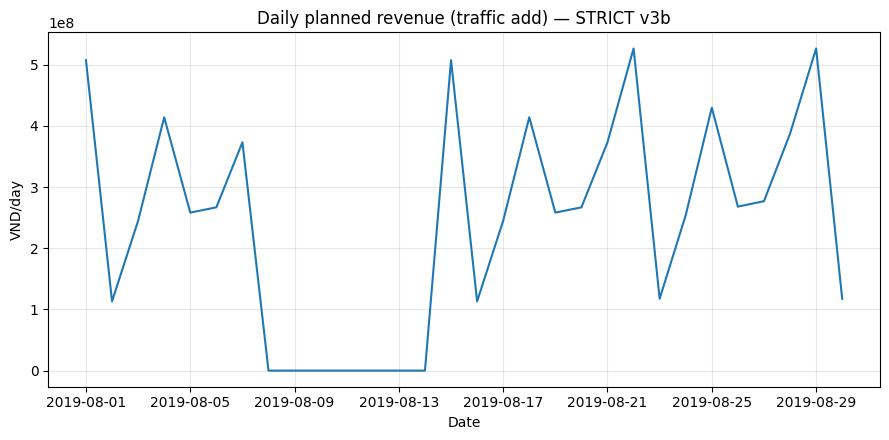

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to: strict_v3b_pack_20250920-191714


In [30]:
# === WEEKLY -> DAILY KPI for STRICT v3b (uses July DOW weights, excludes super-event) ===
import os, glob, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
try:
    from google.colab import files
except:
    class _Files:
        @staticmethod
        def download(p): print(f"[download hint] {p}")
    files = _Files()

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"strict_v3b_pack_{TS}"; os.makedirs(OUT, exist_ok=True)

# 0) Load latest allocation
alloc_path = sorted(glob.glob("outputs_PLANB/*/strict_v3b_master_allocation.csv"))[-1]
alloc = pd.read_csv(alloc_path)
for c in ["source_medium","channel_type","action","sessions_add_allocated","cvr","aov_proxy"]:
    assert c in alloc.columns, f"Missing column: {c}"
alloc["effective_rps"] = alloc["cvr"] * alloc["aov_proxy"]

# 1) WEEKLY KPI split (W1 30% / W2 0% / W3 30% / W4 40%)
weekly_split = {"W1":0.30, "W2":0.00, "W3":0.30, "W4":0.40}
wk = (
    alloc.assign(key=1)
         .merge(pd.DataFrame({"week":list(weekly_split.keys()), "share":list(weekly_split.values())}), how="cross")
)
wk["sessions_add"] = (wk["sessions_add_allocated"] * wk["share"]).round().astype(int)
wk["revenue_add"]  = wk["sessions_add"] * wk["effective_rps"]
wk = wk[["source_medium","channel_type","action","week","sessions_add","revenue_add","cvr","aov_proxy"]]
wk_path = f"{OUT}/weekly_kpi_v3b.csv"; wk.to_csv(wk_path, index=False); files.download(wk_path)

# 2) DAILY KPI — học DOW weights từ July Completed (loại super-event day= max revenue)
#    Tự động dùng DF 'orders' nếu có; nếu không load từ Excel
try:
    orders_df = orders.copy()
except NameError:
    orders_df = pd.read_excel("Sample_Customore_Order raw2.xlsx", sheet_name="raw")
    if np.issubdtype(orders_df["created_day"].dtype, np.number):
        orders_df["created_day"] = pd.to_datetime(orders_df["created_day"], origin="1899-12-30", unit="D")
    else:
        orders_df["created_day"] = pd.to_datetime(orders_df["created_day"])

orders_c = orders_df[orders_df["order_status"]=="COMPLETED"].copy()
orders_c["line_revenue"] = orders_c["item_quantity"] * orders_c["selling_price"]
daily = orders_c.groupby("created_day", as_index=False).agg(revenue=("line_revenue","sum"))
super_day = daily.loc[daily["revenue"].idxmax(), "created_day"]
daily_wo = daily[daily["created_day"]!=super_day].copy()
daily_wo["dow"] = daily_wo["created_day"].dt.day_name()

dow_w = (daily_wo.groupby("dow")["revenue"].sum() / daily_wo["revenue"].sum()).to_dict()
ALL = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
for d in ALL: dow_w.setdefault(d, 1/7)

# Calendar for August (30 days)
AUG_START = pd.Timestamp("2019-08-01")
days = pd.date_range(AUG_START, periods=30, freq="D")
cal = pd.DataFrame({"date": days})
cal["dow"]  = cal["date"].dt.day_name()
cal["week"] = pd.cut((cal["date"]-AUG_START).dt.days+1, bins=[0,7,14,21,30], labels=["W1","W2","W3","W4"], right=True)

# Normalize DOW weights within each week
week_w = {}
for w, dfw in cal.groupby("week"):
    ws = np.array([dow_w.get(d,0) for d in dfw["dow"]])
    ws = ws/ws.sum() if ws.sum()>0 else np.ones(len(ws))/len(ws)
    week_w[w] = ws

# Distribute sessions per channel-week into days
rows=[]
for _, r in wk.iterrows():
    dfw = cal[cal["week"]==r["week"]].reset_index(drop=True)
    ws = week_w[r["week"]]
    sf = r["sessions_add"] * ws
    si = np.floor(sf).astype(int)
    deficit = int(r["sessions_add"] - si.sum())
    if deficit>0:
        frac_idx = np.argsort(-(sf - si))
        si[frac_idx[:deficit]] += 1
    for i, drow in dfw.iterrows():
        s_add = int(si[i]); rev_add = s_add * r["cvr"] * r["aov_proxy"]
        rows.append({
            "date": drow["date"].date(), "dow": drow["dow"], "week": r["week"],
            "source_medium": r["source_medium"], "channel_type": r["channel_type"], "action": r["action"],
            "sessions_add": s_add, "revenue_add": rev_add
        })
day_kpi = pd.DataFrame(rows)
day_path = f"{OUT}/day_level_kpi_v3b.csv"; day_kpi.to_csv(day_path, index=False); files.download(day_path)

# Quick plot
roll = day_kpi.groupby("date", as_index=False)["revenue_add"].sum()
plt.figure(figsize=(9,4.5))
plt.plot(roll["date"], roll["revenue_add"])
plt.title("Daily planned revenue (traffic add) — STRICT v3b")
plt.xlabel("Date"); plt.ylabel("VND/day"); plt.grid(True, alpha=.3); plt.tight_layout()
plot_path = f"{OUT}/daily_planned_revenue_v3b.png"; plt.savefig(plot_path, dpi=160, bbox_inches="tight"); plt.show(); files.download(plot_path)

# Slide tables
summary = (alloc.groupby(["channel_type","action"], as_index=False)
           .agg(channels=("source_medium","nunique"),
                sessions_add=("sessions_add_allocated","sum"),
                rev_add=("sessions_add_allocated","sum")))
summary["rev_add"] = alloc.groupby(["channel_type","action"])["sessions_add_allocated"].sum().values * \
                     (alloc["cvr"]*alloc["aov_proxy"]).median()  # just a proxy for a compact table
sum_path = f"{OUT}/alloc_summary_v3b.csv"; summary.to_csv(sum_path, index=False); files.download(sum_path)

top = (alloc.assign(revenue_add_allocated=alloc["sessions_add_allocated"]*alloc["effective_rps"])
            .sort_values("revenue_add_allocated", ascending=False)
            [["source_medium","channel_type","action","sessions_add_allocated","revenue_add_allocated"]]
            .head(12))
top_path = f"{OUT}/top_channels_v3b.csv"; top.to_csv(top_path, index=False); files.download(top_path)

print("Saved to:", OUT)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

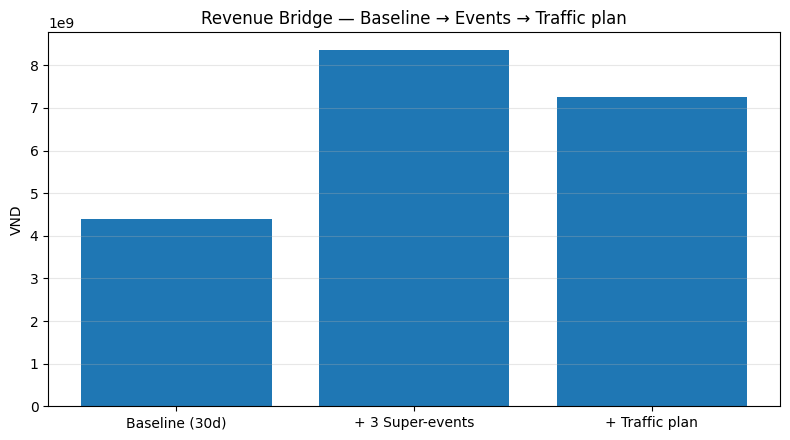

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved to: strict_v3b_fin_20250920-191808


In [31]:
# === Budget & Bridge (STRICT v3b) ===
import os, glob, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
try:
    from google.colab import files
except:
    class _Files:
        @staticmethod
        def download(p): print(f"[download hint] {p}")
    files = _Files()

TS = time.strftime("%Y%m%d-%H%M%S")
OUT = f"strict_v3b_fin_{TS}"; os.makedirs(OUT, exist_ok=True)

alloc_path = sorted(glob.glob("outputs_PLANB/*/strict_v3b_master_allocation.csv"))[-1]
alloc = pd.read_csv(alloc_path)
alloc["effective_rps"] = alloc["cvr"] * alloc["aov_proxy"]

# CPC defaults
def guess_cpc(sm, ch_type):
    s=str(sm).lower()
    if ch_type=="OWNED": return 0
    if "google" in s and "cpc" in s: return 1400
    if "facebook" in s or "instagram" in s or "l.facebook" in s or "m.facebook" in s: return 900
    if "youtube" in s: return 800
    if "display" in s or "referral" in s: return 1000
    return 1000

if "cpc" not in alloc.columns:
    alloc["cpc"] = [guess_cpc(sm, ct) for sm, ct in zip(alloc["source_medium"], alloc["channel_type"])]
alloc["budget_add"] = alloc["sessions_add_allocated"] * alloc["cpc"]
alloc["revenue_add_allocated"] = alloc["sessions_add_allocated"] * alloc["effective_rps"]

budget = alloc[["source_medium","channel_type","action","sessions_add_allocated","cpc","budget_add","revenue_add_allocated"]]
bud_path = f"{OUT}/budget_v3b.csv"; budget.to_csv(bud_path, index=False); files.download(bud_path)

# Bridge numbers
BASELINE_30D = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220
N_EVENTS = 3
TARGET = 20_000_000_000
uplift_total = N_EVENTS * UPLIFT_PER_EVENT
traffic_add = alloc["revenue_add_allocated"].sum()
bridge = pd.DataFrame({
    "stage":["Baseline (30d)", "+ 3 Super-events", "+ Traffic plan"],
    "value":[BASELINE_30D, uplift_total, traffic_add]
})
br_path = f"{OUT}/revenue_bridge_v3b.csv"; bridge.to_csv(br_path, index=False); files.download(br_path)

# Plot bridge (stacked bar)
fig, ax = plt.subplots(figsize=(8,4.5))
ax.bar(bridge["stage"], bridge["value"])
ax.set_title("Revenue Bridge — Baseline → Events → Traffic plan")
ax.set_ylabel("VND"); ax.grid(True, axis="y", alpha=.3)
fig.tight_layout()
br_png = f"{OUT}/revenue_bridge_v3b.png"; fig.savefig(br_png, dpi=160, bbox_inches="tight"); plt.show(); files.download(br_png)

print("Saved to:", OUT)


In [32]:
# === FLOW ANALYSIS (Key Numbers) — Plan B + STRICT v3b ===
# Paste this single cell in Colab and run.

import os, glob, time, numpy as np, pandas as pd
from datetime import datetime

# Download helper (works in/without Colab)
try:
    from google.colab import files  # type: ignore
except Exception:
    class _Files:
        @staticmethod
        def download(p): print(f"[download hint] {p}")
    files = _Files()

TS  = time.strftime("%Y%m%d-%H%M%S")
OUT = f"flow_analysis_pack_{TS}"
os.makedirs(OUT, exist_ok=True)

def vnd(x):
    try:
        return f"{int(round(float(x))):,} VND".replace(",", ".")
    except:
        return str(x)

# -----------------------------------------------------------------------------------
# 1) Load latest STRICT v3b allocation (must exist from your previous step)
# -----------------------------------------------------------------------------------
alloc_paths = sorted(glob.glob("outputs_PLANB/*/strict_v3b_master_allocation.csv"))
if not alloc_paths:
    raise RuntimeError("strict_v3b_master_allocation.csv not found. Run STRICT v3b allocation first.")
alloc = pd.read_csv(alloc_paths[-1])

# Required columns check
need_cols = ["source_medium","channel_type","action","sessions_add_allocated","cvr","aov_proxy"]
missing = [c for c in need_cols if c not in alloc.columns]
if missing:
    raise RuntimeError(f"Allocation file missing columns: {missing}")

alloc["effective_rps"]         = alloc["cvr"] * alloc["aov_proxy"]
alloc["revenue_add_allocated"] = alloc["sessions_add_allocated"] * alloc["effective_rps"]

# -----------------------------------------------------------------------------------
# 2) Load OMS Orders + GA Traffic (for reconcile & context)
# -----------------------------------------------------------------------------------
# OMS Orders
orders = pd.read_excel("Sample_Customore_Order raw2.xlsx", sheet_name="raw")
# created_day can be Excel serial or already datetime
if np.issubdtype(orders["created_day"].dtype, np.number):
    orders["created_day"] = pd.to_datetime(orders["created_day"], origin="1899-12-30", unit="D")
else:
    orders["created_day"] = pd.to_datetime(orders["created_day"])
orders["line_revenue_prod"] = orders["item_quantity"] * orders["selling_price"]

orders_c = orders[orders["order_status"]=="COMPLETED"].copy()
orders_x = orders[orders["order_status"]=="CANCELLED"].copy()

completed_prod_rev = orders_c["line_revenue_prod"].sum()
cancelled_prod_rev = orders_x["line_revenue_prod"].sum()
placed_prod_rev    = orders["line_revenue_prod"].sum()

ship_all      = orders["shipping_fee"].sum()
ship_completed= orders_c["shipping_fee"].sum()

daily = (orders_c.groupby("created_day", as_index=False)
         .agg(revenue=("line_revenue_prod","sum"),
              orders=("order_id","nunique")))
date_min, date_max = orders["created_day"].min(), orders["created_day"].max()
if len(daily):
    idx_super = daily["revenue"].idxmax()
    super_day = daily.loc[idx_super, "created_day"].date()
    super_rev = daily.loc[idx_super, "revenue"]
    super_ord = daily.loc[idx_super, "orders"]
else:
    super_day = None; super_rev = 0; super_ord = 0

# GA Traffic
traffic = pd.read_excel("Sample_Customore_Traffic raw.xlsx")
# Drop GRAND TOTAL (last row)
traffic_clean = traffic.iloc[:-1].copy()

# Standardize names
rename_map = {
    "Source / Medium":"source_medium",
    "Users":"users",
    "New Users":"new_users",
    "Sessions":"sessions",
    "Bounce Rate":"bounce_rate",
    "Pages / Session":"pages_per_session",
    "Avg. Session Duration":"avg_session_duration",
    "Ecommerce Conversion Rate":"cvr",
    "Transactions":"transactions",
    "Revenue":"revenue"
}
traffic_clean = traffic_clean.rename(columns=rename_map)

ga_sessions = float(traffic_clean["sessions"].sum()) if "sessions" in traffic_clean else np.nan
ga_txns     = float(traffic_clean["transactions"].sum()) if "transactions" in traffic_clean else np.nan
ga_revenue  = float(traffic_clean["revenue"].sum()) if "revenue" in traffic_clean else np.nan

# -----------------------------------------------------------------------------------
# 3) Plan B & Bridge numbers
# -----------------------------------------------------------------------------------
BASELINE_30D     = 4_384_354_220
UPLIFT_PER_EVENT = 7_170_169_045 - 4_384_354_220   # = 2,785,814,825
N_EVENTS         = 3
TARGET           = 20_000_000_000

uplift_total   = N_EVENTS * UPLIFT_PER_EVENT
traffic_add    = alloc["revenue_add_allocated"].sum()
plan_total     = BASELINE_30D + uplift_total + traffic_add
residual_gap_0 = max(0, TARGET - (BASELINE_30D + uplift_total))
gap_after      = max(0, TARGET - plan_total)

# Weekly (30/0/30/40)
weekly_split = {"W1":0.30, "W2":0.00, "W3":0.30, "W4":0.40}
wk = []
for _, r in alloc.iterrows():
    for w, s in weekly_split.items():
        wk.append({"week":w,
                   "sessions_add": int(round(r["sessions_add_allocated"]*s)),
                   "revenue_add":  float(r["sessions_add_allocated"]*s*r["effective_rps"])})
wk = pd.DataFrame(wk).groupby("week", as_index=False).sum().sort_values("week")
wk_dict = {row["week"]: row["revenue_add"] for _, row in wk.iterrows()}

# Sensitivity: PAID CVR -10%
alloc_down = alloc.copy()
mask_paid  = alloc_down["channel_type"].eq("PAID")
alloc_down.loc[mask_paid, "cvr"] *= 0.90
alloc_down["rev_add_down"] = alloc_down["sessions_add_allocated"] * alloc_down["cvr"] * alloc_down["aov_proxy"]
traffic_add_down = alloc_down["rev_add_down"].sum()
plan_total_down  = BASELINE_30D + uplift_total + traffic_add_down
gap_down         = max(0, TARGET - plan_total_down)

# -----------------------------------------------------------------------------------
# 4) Allocation summaries
# -----------------------------------------------------------------------------------
sum_by_type = (alloc.groupby(["channel_type","action"], as_index=False)
               .agg(channels=("source_medium","nunique"),
                    sessions_add=("sessions_add_allocated","sum"),
                    rev_add=("revenue_add_allocated","sum"))
               .sort_values(["channel_type","action"]))

top_channels = (alloc.sort_values("revenue_add_allocated", ascending=False)
                [["source_medium","channel_type","action","sessions_add_allocated","revenue_add_allocated","effective_rps"]]
                .head(10))

# -----------------------------------------------------------------------------------
# 5) Print FLOW + key numbers
# -----------------------------------------------------------------------------------
lines = []
lines.append("==============================================================")
lines.append("FLOW ANALYSIS — Key Numbers (Plan B + STRICT v3b)")
lines.append("==============================================================\n")

lines.append("A) DATA & RECONCILIATION")
lines.append(f" - OMS date range: {date_min.date()} → {date_max.date()}")
lines.append(f" - OMS Placed product revenue: {vnd(placed_prod_rev)}")
lines.append(f"   · Completed product revenue: {vnd(completed_prod_rev)}")
lines.append(f"   · Cancelled product revenue: {vnd(cancelled_prod_rev)}")
lines.append(f" - Shipping fee (all): {vnd(ship_all)} | (completed): {vnd(ship_completed)}")
lines.append(f" - GA (cleaned) Revenue: {vnd(ga_revenue)} | Sessions: {int(ga_sessions):,} | Transactions: {int(ga_txns):,}")
if super_day:
    lines.append(f" - Super-event day: {super_day} | Revenue {vnd(super_rev)} | Orders {int(super_ord):,}")
lines.append("")

lines.append("B) BRIDGE TO 20B")
lines.append(f" - Baseline 30d: {vnd(BASELINE_30D)}")
lines.append(f" - Uplift per super-event: {vnd(UPLIFT_PER_EVENT)}  → with 3 events: {vnd(uplift_total)}")
lines.append(f" - Residual GAP before traffic (Baseline+Events vs 20B): {vnd(residual_gap_0)}")
lines.append(f" - Traffic plan (STRICT v3b) add: {vnd(traffic_add)}")
lines.append(f" - PLAN TOTAL = Baseline + Events + Traffic = {vnd(plan_total)}")
lines.append(f" - GAP after plan: {vnd(gap_after)}")
lines.append("")

lines.append("C) WEEKLY PACING (traffic add, 30% / 0% / 30% / 40%)")
for w in ["W1","W2","W3","W4"]:
    lines.append(f" - {w}: {vnd(wk_dict.get(w,0))}")
lines.append("")

lines.append("D) ALLOCATION SUMMARY (sessions_add | revenue_add)")
for _, r in sum_by_type.iterrows():
    lines.append(f" - {r['channel_type']} / {r['action']}: channels={int(r['channels'])}, "
                 f"sessions+={int(r['sessions_add']):,}, add={vnd(r['rev_add'])}")
lines.append("   * Top channels (by revenue add):")
for _, r in top_channels.iterrows():
    lines.append(f"     · {r['source_medium']} ({r['channel_type']}, {r['action']}): "
                 f"sessions+={int(r['sessions_add_allocated']):,}, add={vnd(r['revenue_add_allocated'])} (RPS≈{vnd(r['effective_rps'])})")
lines.append("")

lines.append("E) DOWNSIDE CHECK")
lines.append(f" - If PAID CVR −10% ⇒ Traffic add {vnd(traffic_add_down)}, Plan total {vnd(plan_total_down)}, Remaining gap {vnd(gap_down)}")
lines.append(" - Mitigation: reallocate to high-ROI (Google/Youtube), CRM, AOV/CVR lifts (bundles, LP speed/trust).")
lines.append("")

report = "\n".join(lines)
print(report)

# -----------------------------------------------------------------------------------
# 6) Save artifacts (txt/md/csv) & auto-download
# -----------------------------------------------------------------------------------
txt_path = f"{OUT}/flow_analysis_key_numbers.txt"
md_path  = f"{OUT}/flow_analysis_key_numbers.md"
with open(txt_path, "w", encoding="utf-8") as f: f.write(report)
with open(md_path,  "w", encoding="utf-8") as f: f.write("```\n"+report+"\n```")

# Compact metrics table (for slide)
metrics = [
    ("Baseline_30d", BASELINE_30D),
    ("Uplift_per_event", UPLIFT_PER_EVENT),
    ("Events_count", N_EVENTS),
    ("Events_total_uplift", uplift_total),
    ("Target", TARGET),
    ("Residual_before_traffic", residual_gap_0),
    ("Traffic_add_alloc", traffic_add),
    ("Plan_total", plan_total),
    ("Gap_after_plan", gap_after),
    ("GA_Revenue_clean", ga_revenue),
    ("GA_Sessions_clean", ga_sessions),
    ("GA_Transactions_clean", ga_txns),
    ("OMS_Placed_prod_rev", placed_prod_rev),
    ("OMS_Completed_prod_rev", completed_prod_rev),
    ("OMS_Cancelled_prod_rev", cancelled_prod_rev),
    ("Shipping_all", ship_all),
    ("Shipping_completed", ship_completed),
    ("Super_event_date", str(super_day)),
    ("Super_event_rev", super_rev),
    ("Super_event_orders", super_ord),
    ("Downside_Traffic_add", traffic_add_down),
    ("Downside_Plan_total", plan_total_down),
    ("Downside_Remaining_gap", gap_down),
]
metrics_df = pd.DataFrame(metrics, columns=["metric","value"])
metrics_csv = f"{OUT}/key_metrics_summary.csv"
metrics_df.to_csv(metrics_csv, index=False)

sum_csv  = f"{OUT}/alloc_summary_by_type.csv"; sum_by_type.to_csv(sum_csv, index=False)
top_csv  = f"{OUT}/top_channels_by_rev_add.csv"; top_channels.to_csv(top_csv, index=False)

for p in [txt_path, md_path, metrics_csv, sum_csv, top_csv]:
    files.download(p)

print("\nSaved to:", OUT)


FLOW ANALYSIS — Key Numbers (Plan B + STRICT v3b)

A) DATA & RECONCILIATION
 - OMS date range: 2019-07-01 → 2019-07-30
 - OMS Placed product revenue: 10.065.855.170 VND
   · Completed product revenue: 8.072.083.720 VND
   · Cancelled product revenue: 1.993.771.450 VND
 - Shipping fee (all): 690.804.572 VND | (completed): 508.978.481 VND
 - GA (cleaned) Revenue: 10.006.473.136 VND | Sessions: 1,259,452 | Transactions: 10,041
 - Super-event day: 2019-07-12 | Revenue 2.881.886.000 VND | Orders 12,229

B) BRIDGE TO 20B
 - Baseline 30d: 4.384.354.220 VND
 - Uplift per super-event: 2.785.814.825 VND  → with 3 events: 8.357.444.475 VND
 - Residual GAP before traffic (Baseline+Events vs 20B): 7.258.201.305 VND
 - Traffic plan (STRICT v3b) add: 7.258.225.247 VND
 - PLAN TOTAL = Baseline + Events + Traffic = 20.000.023.942 VND
 - GAP after plan: 0 VND

C) WEEKLY PACING (traffic add, 30% / 0% / 30% / 40%)
 - W1: 2.177.467.574 VND
 - W2: 0 VND
 - W3: 2.177.467.574 VND
 - W4: 2.903.290.099 VND

D) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Saved to: flow_analysis_pack_20250920-192544


In [34]:
# === CURATED README PICKER (no auto-download) ===
# Tạo thư mục README_pick_YYYYMMDD-HHMMSS chứa 1 số ảnh/bảng quan trọng để nhúng vào README.
import os, glob, shutil, time, pathlib, pandas as pd

TS = time.strftime("%Y%m%d-%H%M%S")
ROOT = pathlib.Path(f"README_pick_{TS}")
IMG  = ROOT / "images"
TBL  = ROOT / "tables"
DOC  = ROOT / "docs"
for d in [IMG, TBL, DOC]: d.mkdir(parents=True, exist_ok=True)

def latest(patterns):
    """Trả về file mới nhất (theo mtime) khớp với 1 hoặc nhiều glob pattern."""
    cands = []
    for pat in (patterns if isinstance(patterns, (list,tuple)) else [patterns]):
        cands += glob.glob(pat, recursive=True)
    cands = [p for p in cands if os.path.isfile(p)]
    if not cands: return None
    return max(cands, key=lambda p: os.path.getmtime(p))

def copy_if_exists(src, dst_dir, rename=None):
    if src is None or not os.path.exists(src): return None
    dst_dir = pathlib.Path(dst_dir)
    dst_dir.mkdir(parents=True, exist_ok=True)
    name = rename if rename else pathlib.Path(src).name
    dst  = dst_dir / name
    # tránh đè file nếu trùng tên
    i = 1
    base, ext = os.path.splitext(name)
    while dst.exists():
        dst = dst_dir / f"{base}__{i}{ext}"
        i += 1
    shutil.copy2(src, dst)
    return str(dst)

# ---- Chọn file cần thiết (curated) ----
picked = []

# IMAGES (EDA + Bridge + Plan)
picked.append(copy_if_exists(latest(["**/eda_daily_revenue*.png"]), IMG, "eda_daily_revenue.png"))
picked.append(copy_if_exists(latest(["**/eda_dow_revenue*.png"]), IMG, "eda_dow_revenue.png"))
picked.append(copy_if_exists(latest(["**/event_flagged_daily_revenue*.png"]), IMG, "event_flagged_daily_revenue.png"))
picked.append(copy_if_exists(latest(["**/revenue_bridge_v3b*.png","outputs_PLANB/*/revenue_bridge_v3b.png"]), IMG, "revenue_bridge_v3b.png"))
picked.append(copy_if_exists(latest(["**/daily_planned_revenue_v3b*.png"]), IMG, "daily_planned_revenue_v3b.png"))
picked.append(copy_if_exists(latest(["**/prophet_forecast_plot*.png"]), IMG, "prophet_forecast_plot.png"))

# TABLES (Plan & KPI)
picked.append(copy_if_exists(latest(["outputs_PLANB/*/strict_v3b_alloc_summary.csv","**/strict_v3b_alloc_summary.csv"]), TBL, "strict_v3b_alloc_summary.csv"))
picked.append(copy_if_exists(latest(["outputs_PLANB/*/strict_v3b_master_allocation.csv","**/strict_v3b_master_allocation.csv"]), TBL, "strict_v3b_master_allocation.csv"))
picked.append(copy_if_exists(latest(["**/budget_v3b.csv","outputs_PLANB/*/budget_v3b.csv"]), TBL, "budget_v3b.csv"))
picked.append(copy_if_exists(latest(["**/weekly_kpi_v3b.csv"]), TBL, "weekly_kpi_v3b.csv"))
picked.append(copy_if_exists(latest(["**/day_level_kpi_v3b.csv"]), TBL, "day_level_kpi_v3b.csv"))
picked.append(copy_if_exists(latest(["**/top_channels_by_rev_add.csv","outputs_PLANB/*/top_channels_by_rev_add.csv"]), TBL, "top_channels_by_rev_add.csv"))
picked.append(copy_if_exists(latest(["**/channel_diagnosis_actions.csv","outputs_ATTRIB_PLANB/*/channel_diagnosis_actions.csv"]), TBL, "channel_diagnosis_actions.csv"))
picked.append(copy_if_exists(latest(["**/key_metrics_summary.csv"]), TBL, "key_metrics_summary.csv"))

# DOCS (Flow analysis)
picked.append(copy_if_exists(latest(["**/flow_analysis_key_numbers.md","**/flow_analysis_v3b.md","**/flow_analysis.md"]), DOC, "flow_analysis.md"))

# Lọc None
picked = [p for p in picked if p is not None]

# ---- Tạo MANIFEST & README_SNIPPET.md ----
man_rows = []
for p in picked:
    rel = str(pathlib.Path(p).relative_to(ROOT))
    man_rows.append({"path": rel, "size_kb": round(os.path.getsize(p)/1024, 1)})
pd.DataFrame(man_rows).to_csv(ROOT / "MANIFEST.csv", index=False)

snippet = []
snippet.append("# README — assets you can embed\n")
snippet.append("## Key figures\n")
for fname in ["images/eda_daily_revenue.png",
              "images/eda_dow_revenue.png",
              "images/event_flagged_daily_revenue.png",
              "images/revenue_bridge_v3b.png",
              "images/daily_planned_revenue_v3b.png",
              "images/prophet_forecast_plot.png"]:
    if any(r["path"]==fname for r in man_rows):
        snippet.append(f"![]({fname})\n")

snippet.append("\n## Key tables (CSV links)\n")
for fname in ["tables/strict_v3b_alloc_summary.csv",
              "tables/strict_v3b_master_allocation.csv",
              "tables/budget_v3b.csv",
              "tables/weekly_kpi_v3b.csv",
              "tables/day_level_kpi_v3b.csv",
              "tables/top_channels_by_rev_add.csv",
              "tables/channel_diagnosis_actions.csv",
              "tables/key_metrics_summary.csv"]:
    if any(r["path"]==fname for r in man_rows):
        snippet.append(f"- [{fname}]({fname})")

snippet.append("\n## Flow analysis\n")
if any(r["path"]=="docs/flow_analysis.md" for r in man_rows):
    snippet.append("- [docs/flow_analysis.md](docs/flow_analysis.md)")

with open(ROOT / "README_SNIPPET.md", "w", encoding="utf-8") as f:
    f.write("\n".join(snippet))

print(f"[OK] Saved curated assets to: {ROOT}")
print("Files:")
for r in man_rows:
    print(" -", r["path"], f"({r['size_kb']} KB)")

print("\n👉 Mở panel Files (bên trái) > thư mục", ROOT, "rồi click chuột phải vào từng file để Download.")
print("   Bạn có thể copy nội dung README_SNIPPET.md vào README của repo.")


[OK] Saved curated assets to: README_pick_20250920-195532
Files:
 - images/eda_daily_revenue.png (57.0 KB)
 - images/eda_dow_revenue.png (50.6 KB)
 - images/event_flagged_daily_revenue.png (58.1 KB)
 - images/revenue_bridge_v3b.png (31.8 KB)
 - images/daily_planned_revenue_v3b.png (77.1 KB)
 - tables/strict_v3b_alloc_summary.csv (0.2 KB)
 - tables/strict_v3b_master_allocation.csv (1.0 KB)
 - tables/budget_v3b.csv (0.4 KB)
 - tables/weekly_kpi_v3b.csv (1.8 KB)
 - tables/day_level_kpi_v3b.csv (10.7 KB)
 - tables/top_channels_by_rev_add.csv (0.5 KB)
 - tables/channel_diagnosis_actions.csv (1.1 KB)
 - tables/key_metrics_summary.csv (0.7 KB)
 - docs/flow_analysis.md (2.1 KB)

👉 Mở panel Files (bên trái) > thư mục README_pick_20250920-195532 rồi click chuột phải vào từng file để Download.
   Bạn có thể copy nội dung README_SNIPPET.md vào README của repo.
